In [17]:
import cv2
import pickle
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

In [18]:
# Load the camera calibration mtx,dist parameters produced from the notebook Camera_Calibration.ipynb
CAMERA=pickle.load(open('./calibration.p','rb'))


In [19]:
def undistort(img):
    undist = cv2.undistort(img, CAMERA['mtx'], CAMERA['dist'], None, CAMERA['mtx'])
    return undist

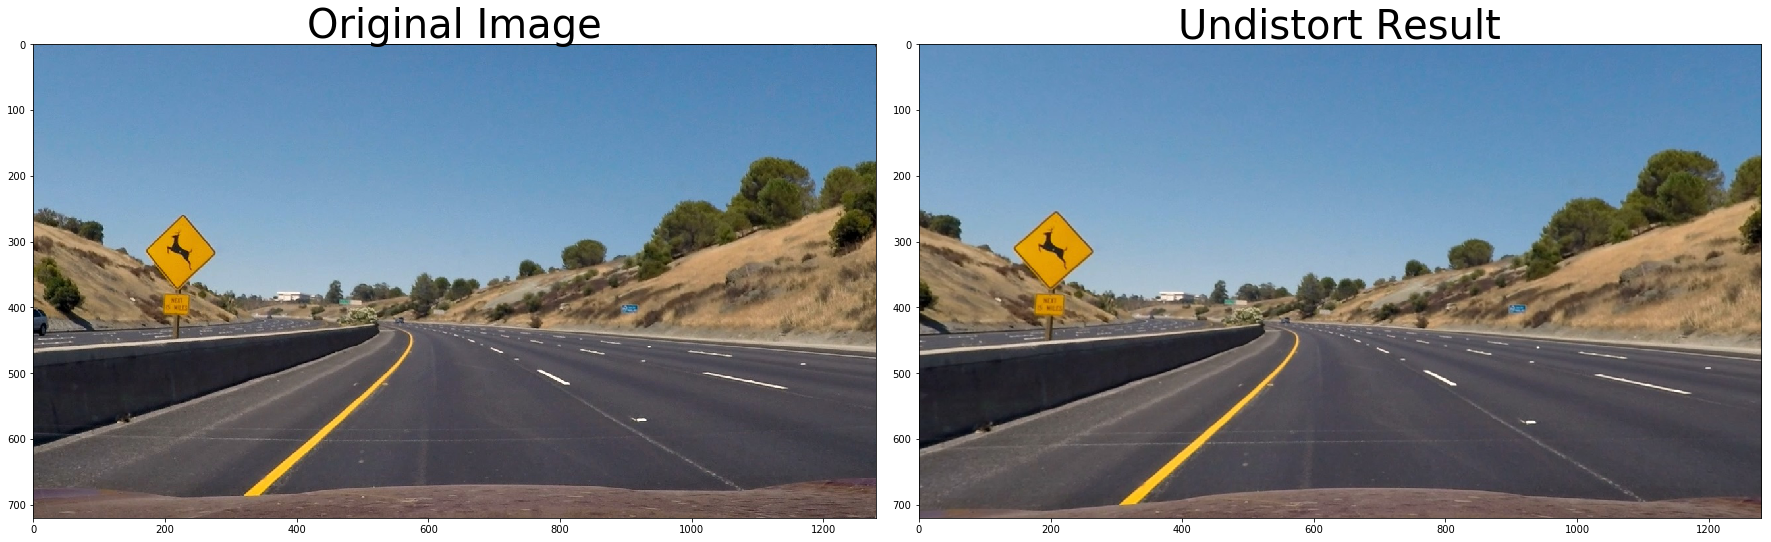

In [20]:
i=2
fname = 'test_images/test{}.jpg'.format(i)
image = mpimg.imread(fname)
result = undistort(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow (image, cmap='gray')
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Undistort Result', fontsize=40)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [21]:
def birds_eye(img):
    # Grab the image shape
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([[490, 482],[810, 482],
                      [1250, 720],[40, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1280, 720],[0, 720]])
    M = cv2.getPerspectiveTransform(src, dst)  # matrix for perspective transform
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size)
    return warped, M, Minv

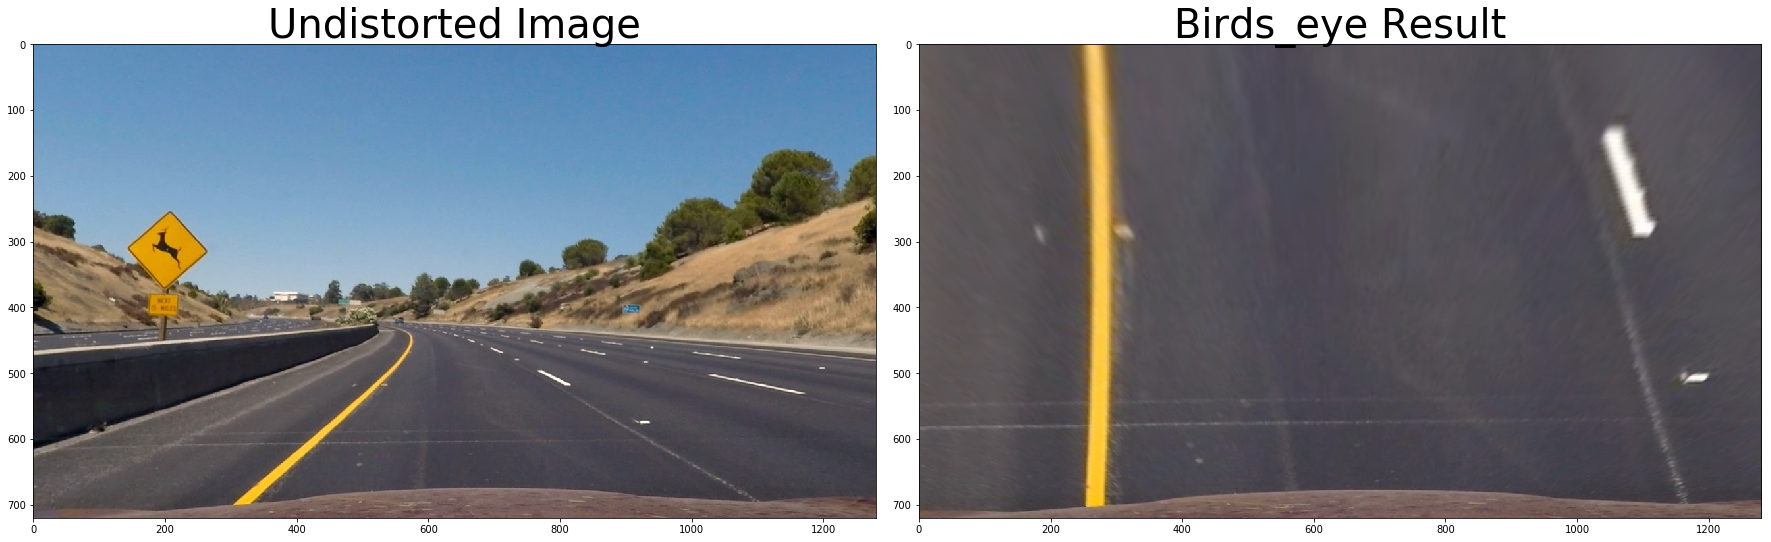

In [22]:
i=2
fname = 'test_images/test{}.jpg'.format(i)
image = mpimg.imread(fname)
und = undistort(image)
pers,_,_= birds_eye(und)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(und)
ax1.set_title('Undistorted Image', fontsize=40)

ax2.imshow(pers, cmap='gray')
ax2.set_title('Birds_eye Result', fontsize=40)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [23]:
# Create binary thresholded images to isolate lane line pixels
def apply_thresholds(img):
    s_channel = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,2] # S channel gets both white and yellow but is distracted by shadows
    l_channel = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)[:,:,0] #L channel great at picking white lane lines but ignores yellow lines
    b_channel = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)[:,:,2] #B channel picks yellow lines perfectly but ignores white lines
    
    # Threshold color channel
    s_thresh_min = 180
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    b_thresh_min = 155
    b_thresh_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    l_thresh_min = 225
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel>=l_thresh_min) & (l_channel<=l_thresh_max)] = 1
    

    combined_binary = np.zeros_like(b_binary)
    combined_binary[(l_binary==1) | (b_binary==1)] = 1
    return combined_binary

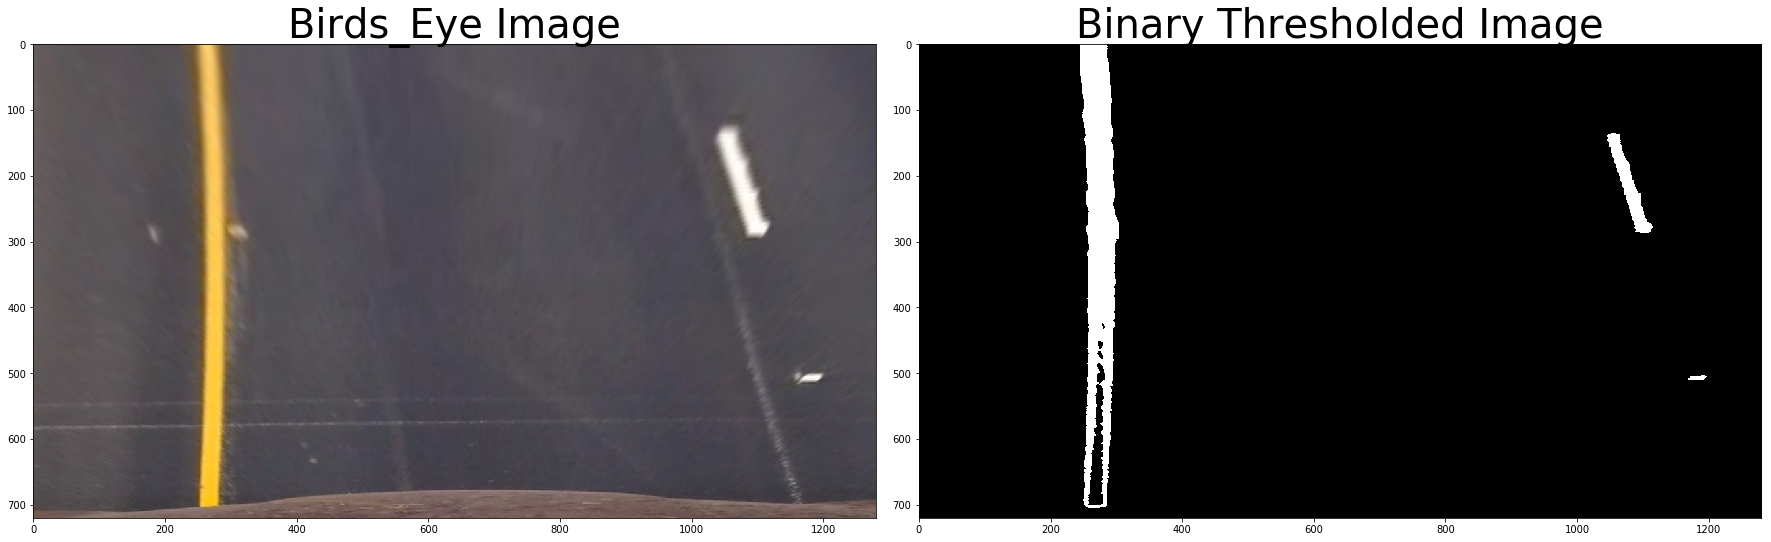

In [24]:
i=2
fname = 'test_images/test{}.jpg'.format(i)
image = mpimg.imread(fname)
und = undistort(image)
pers,_,_= birds_eye(und)
binary_pers=apply_thresholds(pers)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(pers)
ax1.set_title('Birds_Eye Image', fontsize=40)

ax2.imshow(binary_pers, cmap='gray')
ax2.set_title('Binary Thresholded Image', fontsize=40)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [25]:
def find_window_centroids(binary_warped, nwindows=9, margin=100):
    
    """
    Implementation provided by Udacity of lane search with sliding windows
    :param binary_warped: binary warped image with segmented lane lines
    :param nwindows: 
    :param margin:  
    """
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0] / 2):, :], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0] / 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

      # Set height of windows
    window_height = np.int(binary_warped.shape[0] / nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (
        nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (
        nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    


    return left_fit, right_fit, ploty, left_fitx, right_fitx #left_fit[3] and right_fit[3] hold coefficients of 
                                                             # fitted polynomials. left_fitx and right_fitx
                                                             # hold X and Y values of fitted pixels



In [26]:
def search_around_previous_fit(binary_warped, left_fit, right_fit):
    """
    Implement Lane search strategy by only searching the region around the previous lane
    :param binary_warped: 
    :param left_fit: 
    :param right_fit: 
    :return: 
    """

    # Implementation provided by Udacity

    # Assume you now have a new warped binary image
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    print(left_fitx.shape)
    print(right_fitx.shape)
    return left_fit, right_fit, ploty, left_fitx, right_fitx


In [27]:
    def test_get_offset (left_fitx, right_fitx, image_shape=(720,1280)):
        
        #  Find the position of the car from the center
        # It will show if the car is 'x' meters from the left or right
        position = image_shape[1]/2 # Assume Car position is at the center of the image
        lane_center = (right_fitx[719] - left_fitx[719])/2 + left_fitx[719]
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        center_offset_pixels = abs(image_shape[1]/2 - lane_center)
        center_offset_mtrs = xm_per_pix*center_offset_pixels
        return center_offset_mtrs

    def test_get_curvature (y,fitx):
        
                # Define y-value where we want radius of curvature
        # I'll choose the maximum y-value, corresponding to the bottom of the image
        y_eval = np.max(y)
        # Define conversions in x and y from pixels space to meters
        # assume the lane is about 30 meters long and 3.7 meters wide
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meteres per pixel in x dimension
        
        fit_cr = np.polyfit(y * ym_per_pix, fitx * xm_per_pix, 2)
        curverad = ((1 + (2*fit_cr[0]*y_eval + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
        return curverad
    
    def test_fit_lanes (image):
    
        left_fit, right_fit, yvals, left_fitx, right_fitx = \
        find_window_centroids(image,nwindows=8) #this function takes binary warped image
            
        #Find curvatures
        left_curverad=test_get_curvature(yvals,left_fitx)
        right_curverad=test_get_curvature(yvals,right_fitx)        

        return yvals, left_fitx, right_fitx, left_curverad


In [28]:
    def test_draw_poly(image,warped,yvals,left_fitx,right_fitx,Minv,curvature):
    
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
        # Recast the x and y points into usable format for cv2.fillPoly()
        
        pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
        
        #pts_left = np.array([np.flipud(np.transpose(np.vstack([left_fitx, yvals])))])
        #pts_right = np.array([np.transpose(np.vstack([right_fitx, yvals]))])
        
        pts = np.hstack((pts_left, pts_right))
        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0)) #Green color
        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))
        # Combine the result with the original image
        result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
        
        # Put text on an image
        font = cv2.FONT_HERSHEY_SIMPLEX
        text = "Radius of Curvature: {} m".format(int(curvature))
        cv2.putText(result,text,(400,100), font, 1,(255,255,255),2)
        position=test_get_offset(left_fitx,right_fitx)
        text = "Vehicle is {:.2f} offset from center".format(position)
        cv2.putText(result,text,(400,150), font, 1,(255,255,255),2)
        return result

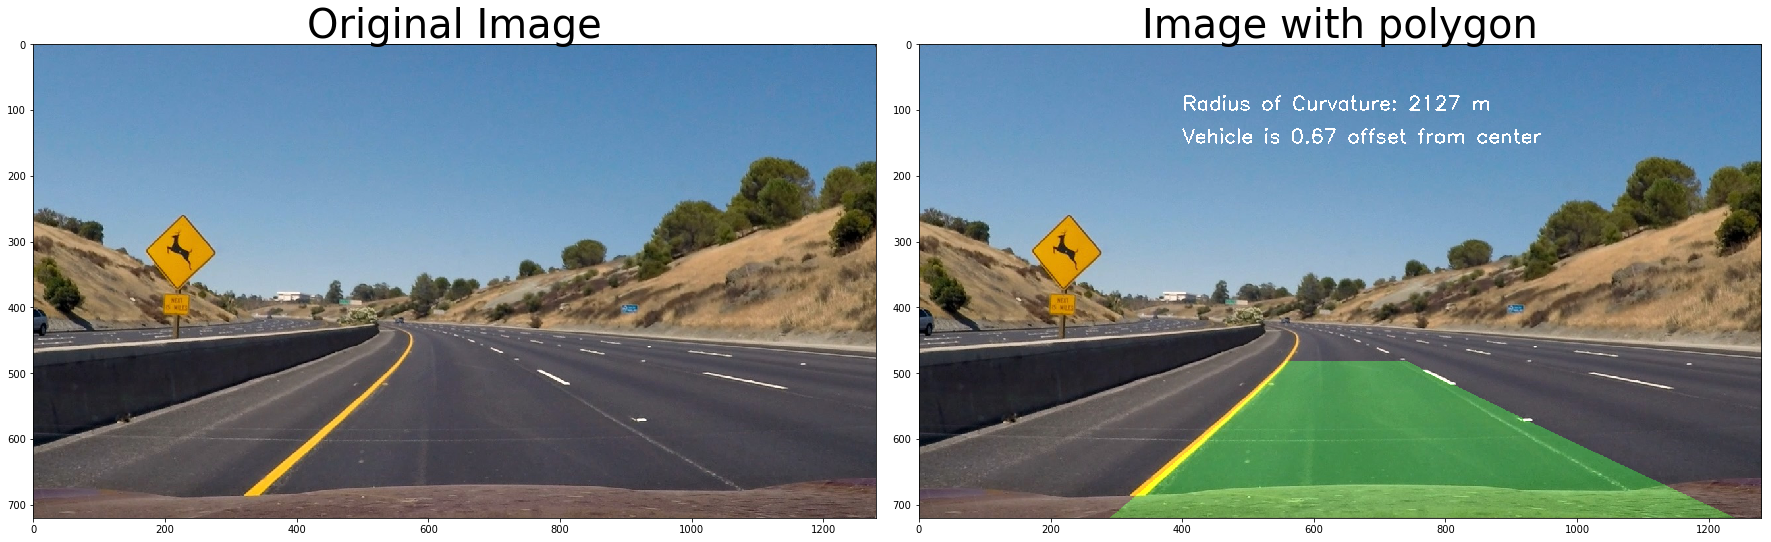

In [29]:
i=2
fname = 'test_images/test{}.jpg'.format(i)
image = mpimg.imread(fname)
und = undistort(image)
pers,M,Minv= birds_eye(und)
binary_pers=apply_thresholds(pers)
yvals, left_fitx, right_fitx, left_curverad=test_fit_lanes(binary_pers)
polygon=test_draw_poly(image,binary_pers,yvals,left_fitx,right_fitx,Minv,left_curverad)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(polygon, cmap='gray')
ax2.set_title('Image with polygon', fontsize=40)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [30]:
class Lane(object):
    """
    An Helper Class to keep track of the detected Lanes
    """

    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False
        # x values of the last n fits of the line
        self.recent_xfitted = []

        self.recent_fits = []
        # average x values of the fitted line over the last n iterations
        self.bestx = None
        # polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        # polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]
        # radius of curvature of the line in some units
        self.radius_of_curvature = None
        # distance in meters of vehicle center from the line
        self.line_base_pos = None
        # difference in fit coefficients between last and new fits
        self.diffs = np.array([0, 0, 0], dtype='float')
        # x values for detected line pixels
        self.allx = None
        # y values for detected line pixels
        self.ally = None
        # x values in windows
        self.windows = np.ones((3, 12)) * -1

In [37]:
class LaneFinder(object):
    """  
    Main class for the project, takes care to fit the lanes to a series of images,
    keep track of the position of the lanes across several images
    
    This class is suppose to process an image after the other through the process image function
    
    """
    def __init__(self):
        
        self.left_lane = Lane()
        self.right_lane = Lane()

        
    @staticmethod
    def get_curvature (y,fitx):
        
                # Define y-value where we want radius of curvature
        # I'll choose the maximum y-value, corresponding to the bottom of the image
        y_eval = np.max(y)
        # Define conversions in x and y from pixels space to meters
        # assume the lane is about 30 meters long and 3.7 meters wide
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meteres per pixel in x dimension
        
        fit_cr = np.polyfit(y * ym_per_pix, fitx * xm_per_pix, 2)
        curverad = ((1 + (2*fit_cr[0]*y_eval + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
        return curverad
    
    @staticmethod
    def get_offset (left_fitx, right_fitx, image_shape=(720,1280)):
        #left_fitx, right_fitx=self.left_fitx, self.right_fitx
        #  Find the position of the car from the center
        # It will show if the car is 'x' meters from the left or right
        position = image_shape[1]/2 # Assume Car position is at the center of the image
        lane_center = (right_fitx[719] - left_fitx[719])/2 + left_fitx[719]
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        center_offset_pixels = abs(image_shape[1]/2 - lane_center)
        center_offset_mtrs = xm_per_pix*center_offset_pixels
        return center_offset_mtrs
    
    @staticmethod
    def sanity_check(lane, curverad, fitx, fit):
        
        # Sanity check for the lane
        lane.current_fit = fitx   #Not sure why it was fit before

        if abs(curverad - 2000) / 2000 < 2:
            lane.detected = True

            #Keep a running average over 3 frames
            if len(lane.recent_xfitted) > 5 and lane.recent_xfitted:
                lane.recent_xfitted.pop()
                lane.recent_fits.pop()

            lane.recent_xfitted.append(fitx.reshape(1,-1))
            lane.recent_fits.append(fit.reshape(1,-1))

            if len(lane.recent_xfitted) > 1:
                lane.bestx = np.mean(np.vstack(lane.recent_xfitted),axis=1)
                lane.best_fit = np.mean(np.vstack(lane.recent_fits),axis=1)

            lane.bestx = fitx
            lane.best_fit = fit

            return lane.bestx

        else:
            lane.detected=False

        return  lane.bestx if lane.bestx is not None else lane.current_fit     
    
    
    def _fit_lanes (self,image):
        left_lane, right_lane=self.left_lane, self.right_lane
        
        if left_lane.detected and right_lane.detected:
            left_fit, right_fit, yvals, left_fitx, right_fitx= \
            search_around_previous_fit(image,left_lane.best_fit, right_lane.best_fit) #takes binary_warped
            
        else:
            left_fit, right_fit, yvals, left_fitx, right_fitx = \
            find_window_centroids(image,nwindows=8) #this function takes binary warped image
            
        #Find curvatures
        left_curverad=self.get_curvature(yvals,left_fitx)
        right_curverad=self.get_curvature(yvals,right_fitx)
        
        print(left_curverad)
        print(right_curverad)
        
        left_fitx = self.sanity_check(left_lane, left_curverad, left_fitx, left_fit)
        right_fitx = self.sanity_check(right_lane, right_curverad, right_fitx, right_fit)
        
        return yvals, left_fitx, right_fitx, left_curverad
    
    @staticmethod
    def draw_poly(image,warped,yvals,left_fitx,right_fitx,Minv,curvature):
    
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
        # Recast the x and y points into usable format for cv2.fillPoly()
        #pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
        #pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
        
        #print(right_fitx.shape)
        #print(left_fitx.shape)
        #print(yvals.shape)
        
        pts_left = np.array([np.flipud(np.transpose(np.vstack([left_fitx, yvals])))])
        pts_right = np.array([np.transpose(np.vstack([right_fitx, yvals]))])
        #print(pts_left.shape)
        #print(pts_right.shape)
        pts = np.hstack((pts_left, pts_right))
        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0)) #Green color
        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))
        # Combine the result with the original image
        result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
        
        # Put text on an image
        font = cv2.FONT_HERSHEY_SIMPLEX
        text = "Radius of Curvature: {} m".format(int(curvature))
        cv2.putText(result,text,(400,100), font, 1,(255,255,255),2)
        position=LaneFinder.get_offset(left_fitx,right_fitx)
        text = "Vehicle is {:.2f} offset from center".format(position)
        cv2.putText(result,text,(400,150), font, 1,(255,255,255),2)
        return result
    
    def process_image (self, image):
        #Main function of the class that processes each image
        
        #Step 1 Undistort image
        undist=undistort(image)
        # Step 2 Apply perspective transform to get bird's eye view of undistorted image
        warped, perspective_M, perspective_Minv = birds_eye(undist)
        #Step 3 Get a binary_warped image containing lane lines as white, rest of the image black
        binary_warped=apply_thresholds(warped)
        # 4. Find the lines fitting to left and right lanes
        yvals, left_fitx, right_fitx,  curvature = self._fit_lanes(binary_warped)
        # 5. Return the original image with colored region
        return self.draw_poly(image, binary_warped, yvals, left_fitx, right_fitx, perspective_Minv, curvature)



In [38]:
## Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
# Set up lines for left and right
LF = LaneFinder()
output = 'output.mp4'
clip1 = VideoFileClip("project_video.mp4")

white_clip = clip1.fl_image(LF.process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

2662.60944393
10417.3971739
[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4



  0%|          | 1/1261 [00:00<02:14,  9.38it/s]

2662.60944393
10417.3971739



  0%|          | 2/1261 [00:00<02:23,  8.77it/s]

2517.12622735
2455.36440764



  0%|          | 3/1261 [00:00<02:23,  8.74it/s]

(720,)
(720,)
2420.44270629
2140.24543978



  0%|          | 4/1261 [00:00<02:23,  8.78it/s]

(720,)
(720,)
2303.61421522
2166.15867279



  0%|          | 5/1261 [00:00<02:22,  8.83it/s]

(720,)
(720,)
1930.81895977
2191.47938528



  0%|          | 6/1261 [00:00<02:23,  8.75it/s]

(720,)
(720,)
1924.31943821
2031.28534886



  1%|          | 7/1261 [00:00<02:22,  8.83it/s]

(720,)
(720,)
1960.77944879
1854.72080039



  1%|          | 8/1261 [00:00<02:21,  8.85it/s]

(720,)
(720,)
1957.2794
10534.9031336



  1%|          | 9/1261 [00:01<02:22,  8.78it/s]

2043.75722563
9637.03713452



  1%|          | 10/1261 [00:01<02:21,  8.82it/s]

1966.47234083
6726.10553881



  1%|          | 11/1261 [00:01<02:22,  8.77it/s]

1879.50122556
11221.5105936



  1%|          | 12/1261 [00:01<02:21,  8.81it/s]

1945.84951497
9021.53521085



  1%|          | 13/1261 [00:01<02:21,  8.84it/s]

1946.73389098
5068.63226477



  1%|          | 14/1261 [00:01<02:22,  8.78it/s]

(720,)
(720,)
1973.82654368
5250.26686375



  1%|          | 15/1261 [00:01<02:22,  8.72it/s]

(720,)
(720,)
1957.87674865
1835.94409299



  1%|▏         | 16/1261 [00:01<02:21,  8.79it/s]

(720,)
(720,)
2005.30248108
1939.16025172



  1%|▏         | 17/1261 [00:01<02:22,  8.74it/s]

(720,)
(720,)
1863.50158034
1981.9592562



  1%|▏         | 18/1261 [00:02<02:24,  8.61it/s]

(720,)
(720,)
1844.38792073
2272.17592463



  2%|▏         | 19/1261 [00:02<02:21,  8.80it/s]

(720,)
(720,)
1873.08006359
2725.55323274



  2%|▏         | 20/1261 [00:02<02:21,  8.74it/s]

(720,)
(720,)
1916.71268384
3704.85715511



  2%|▏         | 21/1261 [00:02<02:23,  8.67it/s]

(720,)
(720,)
2149.33128625
2339.9614135



  2%|▏         | 22/1261 [00:02<02:21,  8.78it/s]

(720,)
(720,)
2635.30131952
2420.84021362



  2%|▏         | 23/1261 [00:02<02:21,  8.75it/s]

(720,)
(720,)
3952.36281114
2530.61985181



  2%|▏         | 24/1261 [00:02<02:22,  8.70it/s]

(720,)
(720,)
4022.78395619
2970.98781677



  2%|▏         | 25/1261 [00:02<02:19,  8.86it/s]

(720,)
(720,)
4806.32951167
2942.84608518



  2%|▏         | 26/1261 [00:02<02:24,  8.52it/s]

(720,)
(720,)
9468.07698892
2685.79509063



  2%|▏         | 27/1261 [00:03<02:25,  8.46it/s]

10686.8494564
3441.08484674



  2%|▏         | 28/1261 [00:03<02:24,  8.52it/s]

21599.8312779
2513.04627368



  2%|▏         | 29/1261 [00:03<02:22,  8.63it/s]

12207.9543297
2540.31375316



  2%|▏         | 30/1261 [00:03<02:27,  8.36it/s]

3211.45614115
1920.66827569



  2%|▏         | 31/1261 [00:03<02:24,  8.53it/s]

(720,)
(720,)
2331.62015704
1906.00644833



  3%|▎         | 32/1261 [00:03<02:23,  8.56it/s]

(720,)
(720,)
2090.79028334
1819.51720221



  3%|▎         | 33/1261 [00:03<02:24,  8.49it/s]

(720,)
(720,)
2064.78312707
1892.65964788



  3%|▎         | 34/1261 [00:03<02:23,  8.53it/s]

(720,)
(720,)
1989.02990303
10022.6224099



  3%|▎         | 35/1261 [00:04<02:23,  8.56it/s]

2019.72385896
16214.5241089



  3%|▎         | 36/1261 [00:04<02:23,  8.53it/s]

1976.55700386
7484.1627517



  3%|▎         | 37/1261 [00:04<02:22,  8.60it/s]

2022.91391056
4481.32690183



  3%|▎         | 38/1261 [00:04<02:23,  8.52it/s]

(720,)
(720,)
1978.13312898
7662.92305151



  3%|▎         | 39/1261 [00:04<02:25,  8.39it/s]

2095.95405135
8635.61412411



  3%|▎         | 40/1261 [00:04<02:21,  8.62it/s]

2099.10026288
6522.14428659



  3%|▎         | 41/1261 [00:04<02:20,  8.71it/s]

2031.23536744
3718.11515762



  3%|▎         | 42/1261 [00:04<02:20,  8.68it/s]

(720,)
(720,)
2113.55501803
2038.17860672


(720,)
(720,)
1848.70193827
1952.49177316



  3%|▎         | 44/1261 [00:05<03:53,  5.21it/s]

(720,)
(720,)
1844.21372563
1872.14414883
(720,)
(720,)
1833.0219141
1820.84683922


  4%|▎         | 46/1261 [00:05<03:53,  5.20it/s]

(720,)
(720,)
1829.34834259
15134.7202199
1828.53400822
34151.7555562


  4%|▍         | 49/1261 [00:06<03:41,  5.47it/s]

1827.06301928
9661.36294193
1823.42717775
43080.5992102


  4%|▍         | 50/1261 [00:06<03:44,  5.39it/s]

1827.66132624
4281.37180718
(720,)
(720,)
1841.65653059
14612.4271509


  4%|▍         | 52/1261 [00:06<03:37,  5.55it/s]

1874.97355862
10964.462965
1955.449807
18323.8211557


  4%|▍         | 54/1261 [00:07<03:43,  5.39it/s]

1983.85073853
3098.71451043
(720,)
(720,)
1866.46752226
1852.91121677


  4%|▍         | 56/1261 [00:07<03:41,  5.45it/s]

(720,)
(720,)
1892.76463894
1801.57516361
(720,)
(720,)
1939.68046068
1751.10877862


  5%|▍         | 58/1261 [00:08<03:45,  5.33it/s]

(720,)
(720,)
2009.50066191
1763.73059268
(720,)
(720,)
2170.06082127
37215.1025898


  5%|▍         | 60/1261 [00:08<03:47,  5.27it/s]

2474.42222067
4308.40104745
(720,)
(720,)
2932.68187234
14554.0477528


  5%|▍         | 62/1261 [00:08<03:48,  5.25it/s]

3617.59780515
2283.68833848
(720,)

  5%|▍         | 63/1261 [00:09<03:55,  5.09it/s]


(720,)
4902.05514848
1717.06741335
(720,)
(720,)
7790.84055537
1864.84378215


  5%|▌         | 65/1261 [00:09<03:44,  5.32it/s]

12590.3913751
1859.46437001
9263.5617795
1773.39326663


  5%|▌         | 67/1261 [00:09<03:43,  5.34it/s]

8440.23573946
1890.58972312
3031.16131465

  5%|▌         | 68/1261 [00:09<03:53,  5.10it/s]


2048.76523333


  5%|▌         | 69/1261 [00:10<03:47,  5.25it/s]

(720,)
(720,)
2307.77142822
2302.05320279
(720,)
(720,)
2052.78427195
1971.53436448


  6%|▌         | 71/1261 [00:10<03:41,  5.37it/s]

(720,)
(720,)
1900.65107726
2247.71831973
(720,)
(720,)
1850.78719567
2216.58010834


  6%|▌         | 73/1261 [00:10<03:49,  5.18it/s]

(720,)
(720,)
1840.45761173
2378.65895642


  6%|▌         | 74/1261 [00:11<03:51,  5.13it/s]

(720,)
(720,)
1837.55441864
2482.07206423
(720,)

  6%|▌         | 75/1261 [00:11<03:54,  5.07it/s]


(720,)
1838.90775576
2615.79437232
(720,)
(720,)
1873.52501556
3286.16208579


  6%|▌         | 77/1261 [00:11<03:48,  5.19it/s]

(720,)
(720,)
2000.31809079
4458.58220483
(720,)
(720,)
2479.19205739
2333.86401074

  6%|▌         | 78/1261 [00:11<03:41,  5.34it/s]


(720,)
(720,)
4330.63808271
2368.51893207


  6%|▋         | 80/1261 [00:12<03:42,  5.32it/s]

(720,)
(720,)
3941.42882128
2232.87402827
(720,)
(720,)
4908.78834355
2012.857426


  7%|▋         | 82/1261 [00:12<04:20,  4.53it/s]

(720,)
(720,)
5783.45956693
1980.01948803


  7%|▋         | 83/1261 [00:13<04:42,  4.17it/s]

(720,)
(720,)
6664.8103918
1869.50507347


  7%|▋         | 85/1261 [00:13<04:20,  4.51it/s]

7132.63946591
6014.461777
7672.92508673
18041.1726982


  7%|▋         | 86/1261 [00:13<04:10,  4.70it/s]

5970.94105703
21367.8725594


  7%|▋         | 87/1261 [00:13<04:05,  4.77it/s]

4109.71574429
19675.1925265
3472.84011063
2607.5808177


  7%|▋         | 89/1261 [00:14<03:50,  5.08it/s]

(720,)
(720,)
3559.07684242
1922.56354193
(720,)
(720,)
3998.79938897
1776.39843843


  7%|▋         | 91/1261 [00:14<03:54,  5.00it/s]

(720,)
(720,)
5429.8751469
1866.35652791
(720,)
(720,)
5647.42265198
1948.59942886


  7%|▋         | 93/1261 [00:15<03:51,  5.05it/s]

(720,)
(720,)
2697.00848381
2001.59543887
(720,)
(720,)
2271.27338251
2391.69823966


  8%|▊         | 95/1261 [00:15<03:40,  5.28it/s]

(720,)
(720,)
2131.7356723
2370.24597142
(720,)
(720,)
2035.67895541
2051.09857983


  8%|▊         | 97/1261 [00:15<03:42,  5.23it/s]

(720,)
(720,)
2001.21739967
2071.68594563
(720,)
(720,)
1940.56278425
2048.24858388


  8%|▊         | 99/1261 [00:16<03:48,  5.09it/s]

(720,)
(720,)
1901.40965497
2109.24645429
(720,)
(720,)
1939.33861346
2225.87510007


  8%|▊         | 101/1261 [00:16<03:43,  5.18it/s]

(720,)
(720,)
2014.17561577
2476.89750891


  8%|▊         | 102/1261 [00:16<03:56,  4.91it/s]

(720,)
(720,)
2106.69149513
1802.75426048
(720,)
(720,)
2460.99641615
1834.72389444


  8%|▊         | 104/1261 [00:17<03:46,  5.10it/s]

(720,)
(720,)
2877.22307104
1864.93692294


  8%|▊         | 105/1261 [00:17<04:12,  4.58it/s]

(720,)
(720,)
3469.7928396
1873.49227906


  8%|▊         | 106/1261 [00:17<03:55,  4.91it/s]

(720,)
(720,)
2479.28923107
1822.73609014
(720,)
(720,)
2568.98399804
1796.58194971


  9%|▊         | 108/1261 [00:17<03:50,  5.01it/s]

(720,)
(720,)
2378.23296203
1765.80738144
(720,)
(720,)
2365.23016277
5166.08688902


  9%|▊         | 110/1261 [00:18<03:39,  5.25it/s]

(720,)
(720,)
2230.00715218
3748.63023812
(720,)
(720,)
2236.91385776
5971.9161241


  9%|▉         | 112/1261 [00:18<03:37,  5.27it/s]

(720,)
(720,)
2201.79220577
7364.26898031
2192.6175084

  9%|▉         | 113/1261 [00:18<03:53,  4.92it/s]


4584.48176333


  9%|▉         | 114/1261 [00:19<03:48,  5.03it/s]

(720,)
(720,)
2363.34699614
5391.73397494
(720,)
(720,)
2350.74316405
3437.52863394


  9%|▉         | 116/1261 [00:19<03:44,  5.10it/s]

(720,)
(720,)
2408.11141318
2809.28389438
(720,)
(720,)
2431.51374338
2832.41915139


  9%|▉         | 118/1261 [00:19<03:39,  5.20it/s]

(720,)
(720,)
2030.01482091
2314.56627824
(720,)
(720,)
1978.82888202
2039.7414583


 10%|▉         | 120/1261 [00:20<03:42,  5.13it/s]

(720,)
(720,)
1924.41140601
1810.11492234
(720,)
(720,)
1946.59753644
1790.6365736


 10%|▉         | 122/1261 [00:20<03:48,  4.99it/s]

(720,)
(720,)
1935.94621544
5996.48401757


 10%|▉         | 123/1261 [00:20<03:40,  5.17it/s]

(720,)
(720,)
1921.13180043
6749.28349571
1918.47430414
13008.0457235


 10%|▉         | 125/1261 [00:21<03:44,  5.07it/s]

1917.36902038
6123.09049545
1938.07964621
3730.6286956


 10%|█         | 127/1261 [00:21<03:42,  5.09it/s]

(720,)
(720,)
1977.26880189
14453.296433


 10%|█         | 128/1261 [00:21<03:37,  5.21it/s]

2061.84181956
32103.8002877
2038.28791685
8035.51267454


 10%|█         | 130/1261 [00:22<03:35,  5.24it/s]

1862.79461979
2179.63050385
(720,)
(720,)
1848.15677055
1763.45390819


 10%|█         | 132/1261 [00:22<03:37,  5.19it/s]

(720,)
(720,)
1845.39192668
1756.508644
(720,)
(720,)
1850.7855379
1775.43206471


 11%|█         | 134/1261 [00:23<03:51,  4.87it/s]

(720,)
(720,)
1845.59945739
2316.01579834


 11%|█         | 135/1261 [00:23<03:55,  4.78it/s]

(720,)
(720,)
1888.99504322
3066.14255647
(720,)
(720,)
1976.43252134
3304.19964279


 11%|█         | 137/1261 [00:23<03:48,  4.93it/s]

(720,)
(720,)
2004.25875308
3281.7636284
(720,)
(720,)
2174.39476081
3541.50413945


 11%|█         | 139/1261 [00:24<03:42,  5.04it/s]

(720,)
(720,)
2653.5203094
6426.67966159
3574.83086485
20122.0007846


 11%|█         | 141/1261 [00:24<03:41,  5.05it/s]

5083.05684843
8719.35081487
7060.30863683
4991.44329359


 11%|█▏        | 143/1261 [00:24<03:38,  5.11it/s]

2765.57061613
2114.72431138
(720,)

 11%|█▏        | 144/1261 [00:25<03:39,  5.08it/s]


(720,)
2571.8073675
1881.65221989
(720,)
(720,)
2190.66203918
1864.97118845


 12%|█▏        | 146/1261 [00:25<03:34,  5.21it/s]

(720,)
(720,)
2012.30536209
1804.42790789
(720,)
(720,)
1965.67757177
12783.0777158


 12%|█▏        | 148/1261 [00:25<03:29,  5.31it/s]

1901.97129017
3607.29504522
(720,)
(720,)
1938.86102409
166239.825475


 12%|█▏        | 150/1261 [00:26<03:36,  5.14it/s]

2043.27921912
3273.12082662
(720,)
(720,)
2127.30461631
7112.32739283


 12%|█▏        | 152/1261 [00:26<03:38,  5.07it/s]

2533.15935713
8829.26431769


 12%|█▏        | 153/1261 [00:26<03:38,  5.07it/s]

2914.61853638
40155.6002582
3432.672859
8547.45557977


 12%|█▏        | 155/1261 [00:27<03:35,  5.14it/s]

2950.65413635
4863.6046379
(720,)
(720,)
3905.17385589
2980.44254731


 12%|█▏        | 157/1261 [00:27<03:37,  5.09it/s]

(720,)
(720,)
3626.21631216
2405.02891367
(720,)
(720,)
3158.9830165
1789.69078862


 13%|█▎        | 159/1261 [00:28<03:35,  5.11it/s]

(720,)
(720,)
2634.60095713
2368.77797321
(720,)
(720,)
2448.17787255
2223.21491833


 13%|█▎        | 161/1261 [00:28<03:38,  5.04it/s]

(720,)
(720,)
2162.49107115
2336.59592068
(720,)
(720,)
2144.19244908
2622.22246865


 13%|█▎        | 163/1261 [00:28<03:38,  5.04it/s]

(720,)
(720,)
2180.31912101
2353.93819824


 13%|█▎        | 164/1261 [00:28<03:39,  5.00it/s]

(720,)
(720,)
2292.34228808
1720.76126273
(720,)

 13%|█▎        | 165/1261 [00:29<03:40,  4.96it/s]


(720,)
2415.02394021
2099.54497549
(720,)
(720,)
2584.39039223
2320.80641031


 13%|█▎        | 167/1261 [00:29<03:29,  5.23it/s]

(720,)
(720,)
2168.74840087
2444.17106455
(720,)
(720,)
2185.04137722
2651.17425401


 13%|█▎        | 169/1261 [00:29<03:27,  5.27it/s]

(720,)
(720,)
2154.04177861
3761.24620137
(720,)
(720,)
2107.71190647
3470.00920218


 14%|█▎        | 171/1261 [00:30<03:26,  5.27it/s]

(720,)
(720,)
2048.05455252
3289.1063123
(720,)
(720,)
2072.05741148
3863.199039


 14%|█▎        | 173/1261 [00:30<03:25,  5.28it/s]

(720,)
(720,)
1971.866973
3268.46918005
(720,)
(720,)
1981.74029816
3635.70779282


 14%|█▍        | 175/1261 [00:31<03:25,  5.28it/s]

(720,)
(720,)
2035.42040626
4451.9662928
(720,)
(720,)
2108.89726039
1947.5123951


 14%|█▍        | 177/1261 [00:31<03:26,  5.25it/s]

(720,)
(720,)
2323.27175196
2418.57596894
(720,)
(720,)
2947.33268085
1965.09001859


 14%|█▍        | 179/1261 [00:31<03:32,  5.09it/s]

(720,)
(720,)
5415.77079721
1981.13743812


 14%|█▍        | 180/1261 [00:32<03:31,  5.11it/s]

(720,)
(720,)
5289.78792856
1923.36728838
(720,)
(720,)
8667.81124247
1758.06876557


 14%|█▍        | 182/1261 [00:32<03:23,  5.31it/s]

16787.6126348
1731.57080028
11560.4948855
1757.28066207


 15%|█▍        | 184/1261 [00:32<03:28,  5.18it/s]

5389.10608731
1864.84487638


 15%|█▍        | 185/1261 [00:33<03:35,  5.00it/s]

(720,)
(720,)
3405.03034934
1921.94179409


 15%|█▍        | 186/1261 [00:33<03:34,  5.01it/s]

(720,)
(720,)
2120.445154
2002.43595086
(720,)
(720,)
1960.41641415
2267.69383309


 15%|█▍        | 188/1261 [00:33<03:33,  5.03it/s]

(720,)
(720,)
1862.39754313
1732.72577816
(720,)
(720,)
1846.14833611
1719.79037148


 15%|█▌        | 190/1261 [00:34<03:28,  5.13it/s]

(720,)
(720,)
1839.71444126
1710.07133416
(720,)

 15%|█▌        | 191/1261 [00:34<03:32,  5.03it/s]


(720,)
1845.55836289
1710.60919735


 15%|█▌        | 192/1261 [00:34<03:29,  5.11it/s]

(720,)
(720,)
1836.96354089
1724.31635933
(720,)
(720,)
1841.90872542
1730.36363823


 15%|█▌        | 194/1261 [00:34<03:40,  4.83it/s]

(720,)
(720,)
1877.598893
1733.96816239


 15%|█▌        | 195/1261 [00:35<03:42,  4.79it/s]

(720,)
(720,)
1909.76857951
1738.05637215
(720,)
(720,)
1981.23364591
3028.20961677


 16%|█▌        | 197/1261 [00:35<03:41,  4.80it/s]

(720,)
(720,)
2075.37097576
3380.08850167


 16%|█▌        | 198/1261 [00:35<03:35,  4.93it/s]

(720,)
(720,)
2002.26551815
4061.54664773
(720,)
(720,)
2044.01284918
4877.08096046


 16%|█▌        | 200/1261 [00:36<03:28,  5.09it/s]

(720,)
(720,)
2117.06440872
4920.21095804
(720,)
(720,)
2183.18448309
1933.65072958


 16%|█▌        | 202/1261 [00:36<03:24,  5.18it/s]

(720,)
(720,)
2237.87961422
1930.2926749
(720,)
(720,)
2323.39101601
2687.22030375


 16%|█▌        | 204/1261 [00:36<03:18,  5.32it/s]

(720,)
(720,)
1981.69777902
2674.52875914
(720,)
(720,)
1969.48161887
2017.52457216


 16%|█▋        | 206/1261 [00:37<03:16,  5.37it/s]

(720,)
(720,)
1970.59386129
1905.35968471
(720,)
(720,)
2090.66445003
1739.85076747


 16%|█▋        | 208/1261 [00:37<03:16,  5.36it/s]

(720,)
(720,)
2171.1043241
2414.92911024
(720,)
(720,)
2295.36563964
2346.09188054


 17%|█▋        | 210/1261 [00:38<03:22,  5.18it/s]

(720,)
(720,)
2395.24835115
2611.75633499
(720,)
(720,)
2669.5748189
3023.24443438


 17%|█▋        | 212/1261 [00:38<03:20,  5.23it/s]

(720,)
(720,)
2662.79355321
2925.87338099
(720,)
(720,)
2810.25580456
4563.35840523


 17%|█▋        | 214/1261 [00:38<03:19,  5.25it/s]

(720,)
(720,)
2615.33390925
2562.61679009
(720,)
(720,)
2396.52167628
2264.19833405


 17%|█▋        | 216/1261 [00:39<03:21,  5.18it/s]

(720,)
(720,)
2081.09204042
2254.15118553
(720,)
(720,)
1857.12020121
2109.95065475


 17%|█▋        | 218/1261 [00:39<03:14,  5.35it/s]

(720,)
(720,)
1831.74542146
1825.38119639
(720,)
(720,)
1831.79886393
1743.37106473


 17%|█▋        | 220/1261 [00:39<03:15,  5.33it/s]

(720,)
(720,)
1854.50223893
1723.69347259
(720,)
(720,)
1866.2251698
1748.21570384


 18%|█▊        | 222/1261 [00:40<03:15,  5.31it/s]

(720,)
(720,)
1905.22772194
1753.83854257
(720,)
(720,)
1975.93274422
1825.76843507


 18%|█▊        | 224/1261 [00:40<03:17,  5.25it/s]

(720,)
(720,)
1993.7089678
1839.36970887
(720,)
(720,)
2017.92039002
1710.85693309


 18%|█▊        | 226/1261 [00:41<03:26,  5.01it/s]

(720,)
(720,)
2114.08171012
1735.7865276


 18%|█▊        | 227/1261 [00:41<03:18,  5.20it/s]

(720,)
(720,)
2244.2485446
7434.52699493
2378.77058006
1784.73786329


 18%|█▊        | 229/1261 [00:41<03:15,  5.29it/s]

(720,)
(720,)
2028.20037144
8674.43980024
2104.35950881
4800.97371599


 18%|█▊        | 231/1261 [00:42<03:13,  5.32it/s]

(720,)
(720,)
2191.53902147
3085.05144775
(720,)
(720,)
2286.0998767
2184.18653939


 18%|█▊        | 233/1261 [00:42<03:08,  5.44it/s]

(720,)
(720,)
2352.54887758
22884.6397558
2398.13054027
8193.39429225


 19%|█▊        | 235/1261 [00:42<03:10,  5.39it/s]

2477.1292718
7049.69771432
2309.8197467
10055.6898075


 19%|█▉        | 237/1261 [00:43<03:11,  5.35it/s]

2564.63440286
1831.72235607
(720,)
(720,)
2982.79517863
1804.54377305


 19%|█▉        | 239/1261 [00:43<03:13,  5.30it/s]

(720,)
(720,)
3909.47366697
1938.65421783
(720,)
(720,)
4819.60817319
1978.44391332


 19%|█▉        | 241/1261 [00:43<03:12,  5.29it/s]

(720,)
(720,)
2839.29364086
2038.35231651
(720,)
(720,)
2872.1811025
1996.92849316


 19%|█▉        | 243/1261 [00:44<03:20,  5.08it/s]

(720,)
(720,)
2663.47229047
1897.74840217
(720,)
(720,)
2554.83034643
1758.19480477


 19%|█▉        | 245/1261 [00:44<03:15,  5.20it/s]

(720,)
(720,)
2428.84723019
3729.64774397
(720,)
(720,)
2266.98620968
3942.14728201


 20%|█▉        | 247/1261 [00:45<03:17,  5.13it/s]

(720,)
(720,)
2198.22796764
4386.18312633
(720,)
(720,)
2259.01779327
4587.82493086


 20%|█▉        | 249/1261 [00:45<03:17,  5.13it/s]

(720,)
(720,)
2347.90886189
3269.80176747
(720,)
(720,)
2548.1240658
10730.5399802


 20%|█▉        | 251/1261 [00:45<03:14,  5.19it/s]

2778.54118081
4932.027808
(720,)
(720,)
2973.75737893
1956.48196013


 20%|██        | 253/1261 [00:46<03:16,  5.14it/s]

(720,)
(720,)
2255.743856
2025.11263378


 20%|██        | 254/1261 [00:46<03:14,  5.16it/s]

(720,)
(720,)
2212.40325957
2009.45204077
(720,)
(720,)
2077.03421861

 20%|██        | 256/1261 [00:46<03:03,  5.48it/s]


1923.25636431
(720,)
(720,)
2109.75187579
1772.89790329


 20%|██        | 257/1261 [00:47<03:08,  5.33it/s]

(720,)
(720,)
2007.03602566
3843.43423867
(720,)
(720,)
2056.5184419
3382.48623082


 21%|██        | 259/1261 [00:47<03:05,  5.40it/s]

(720,)
(720,)
2028.49115507
3660.30477887
(720,)
(720,)
2140.29388314
6029.89615876


 21%|██        | 261/1261 [00:47<03:06,  5.37it/s]

2637.71741013
3540.21770637
(720,)
(720,)
3048.89970994
6944.25918806


 21%|██        | 263/1261 [00:48<03:07,  5.33it/s]

3816.0222481
14550.241934
4397.43070628
12386.4535537


 21%|██        | 265/1261 [00:48<03:04,  5.39it/s]

2969.20670955
6317.39353827
2717.0845403
1725.90914924


 21%|██        | 267/1261 [00:48<03:07,  5.31it/s]

(720,)
(720,)
2326.94132404
2210.41424294
(720,)
(720,)
2172.19581972
1923.20463546


 21%|██▏       | 269/1261 [00:49<03:14,  5.11it/s]

(720,)
(720,)
2173.78659916
1794.5535031


 21%|██▏       | 270/1261 [00:49<03:10,  5.19it/s]

(720,)
(720,)
2230.81535087
1743.5028454
(720,)
(720,)
2154.93671514
1771.26846455


 22%|██▏       | 272/1261 [00:49<03:15,  5.05it/s]

(720,)
(720,)
2231.98426661
1781.95549466
(720,)
(720,)
2392.91352157
1827.28339479


 22%|██▏       | 274/1261 [00:50<03:08,  5.23it/s]

(720,)
(720,)
2651.91894448
2210.31715974
(720,)
(720,)
3139.37606337
2952.37968449


 22%|██▏       | 276/1261 [00:50<03:06,  5.27it/s]

(720,)
(720,)
3560.295709
3285.78689306
(720,)
(720,)
2508.98238344
3306.2058152


 22%|██▏       | 278/1261 [00:51<02:59,  5.49it/s]

(720,)
(720,)
2359.09786433
3179.37258206
(720,)
(720,)
2175.39252812
2991.9660177


 22%|██▏       | 280/1261 [00:51<03:01,  5.41it/s]

(720,)
(720,)
2236.16052017
2020.4042108
(720,)
(720,)
2210.03133516
4233.45968616


 22%|██▏       | 282/1261 [00:51<03:02,  5.36it/s]

(720,)
(720,)
2348.67612047
4739.86400224
(720,)
(720,)
2538.19702774
3717.02306365


 23%|██▎       | 284/1261 [00:52<03:03,  5.34it/s]

(720,)
(720,)
2504.50865537
3505.31564248
(720,)
(720,)
2604.91531412
4280.82343354


 23%|██▎       | 286/1261 [00:52<03:01,  5.36it/s]

(720,)
(720,)
3240.4030564
3311.03953481
(720,)
(720,)
4222.00389758
2403.40324872


 23%|██▎       | 288/1261 [00:52<02:58,  5.44it/s]

(720,)
(720,)
4641.66702357
2796.50021383
(720,)
(720,)
2963.61976723
2984.85163788


 23%|██▎       | 290/1261 [00:53<02:56,  5.51it/s]

(720,)
(720,)
3083.44607164
2799.21600784
(720,)
(720,)
3029.64919482
3116.89175317


 23%|██▎       | 292/1261 [00:53<02:54,  5.56it/s]

(720,)
(720,)
2821.85929819
2491.9163143
(720,)
(720,)
3080.54565349
76213.4916197


 23%|██▎       | 295/1261 [00:54<02:49,  5.69it/s]

3075.85592084
59982.8910879
2978.00003233
221884.058244


 23%|██▎       | 296/1261 [00:54<02:56,  5.47it/s]

3031.49307708
52901.5850679
3868.66528999
17496.7150775


 24%|██▎       | 298/1261 [00:54<02:57,  5.42it/s]

5554.93687153
1862.65183287
(720,)
(720,)
11848.3067913
2750.12253753


 24%|██▍       | 300/1261 [00:55<03:02,  5.27it/s]

42390.5218766
1994.93657551
5760.35336577
2622.54526332


 24%|██▍       | 302/1261 [00:55<03:01,  5.29it/s]

(720,)
(720,)
5403.11108264
3226.66052105
(720,)
(720,)
4243.79317138
2838.80682173


 24%|██▍       | 304/1261 [00:55<03:01,  5.26it/s]

(720,)
(720,)
3587.47526148
2319.75452027
(720,)
(720,)
3273.25599788
5326.14450086


 24%|██▍       | 306/1261 [00:56<03:03,  5.20it/s]

(720,)
(720,)
2897.99944454
7325.99027318
2949.66428462
185889.413357


 24%|██▍       | 308/1261 [00:56<03:04,  5.17it/s]

2850.88018545
7807.75658829
3363.40455245
9823.60006656


 25%|██▍       | 310/1261 [00:57<03:02,  5.21it/s]

7260.50415216
2253.88819536
104722.012176
2491.34558581


 25%|██▍       | 312/1261 [00:57<03:04,  5.14it/s]

17199.699476
2096.72083758
16247.6370652
2014.36789557


 25%|██▍       | 314/1261 [00:57<03:03,  5.17it/s]

7234.6603319
9217.49024485
8281.97176596
2598.75318764


 25%|██▌       | 316/1261 [00:58<03:00,  5.25it/s]

7614.65347811
9371.56286535
5579.09710263
2022.15388693


 25%|██▌       | 318/1261 [00:58<02:57,  5.31it/s]

(720,)
(720,)
6490.44740877
2213.34540565
4683.88300313
2079.37478349


 25%|██▌       | 320/1261 [00:58<02:55,  5.37it/s]

(720,)
(720,)
4113.1897855
2155.49829682
(720,)
(720,)
6700.00848977
2242.05745017


 26%|██▌       | 322/1261 [00:59<02:56,  5.33it/s]

16298.1387085
11613.4279418


 26%|██▌       | 324/1261 [00:59<02:50,  5.50it/s]

13951.8946683
155006.402588
6964.16036008
77993.1830774


 26%|██▌       | 325/1261 [00:59<02:56,  5.29it/s]

16147.315328
15781.0635858
24371.0851562

 26%|██▌       | 326/1261 [00:59<02:53,  5.39it/s]


8436.54121955
38678.3013145
8644.71860528


 26%|██▌       | 328/1261 [01:00<02:51,  5.45it/s]

106452.287333
3588.95589543
13134.3767674
12611.4755455


 26%|██▌       | 330/1261 [01:00<02:49,  5.50it/s]

10423.185583
13988.4334732
58596.3070633
4078.86765043


 26%|██▋       | 332/1261 [01:01<02:58,  5.22it/s]

59788.0538513
5305.16652993


 26%|██▋       | 333/1261 [01:01<03:00,  5.13it/s]

14042.5649581
8181.52954496
6274.29792325
3533.98673558


 27%|██▋       | 335/1261 [01:01<02:58,  5.18it/s]

4436.75302581
2948.61390996
(720,)
(720,)
3836.14377654
4692.75281961


 27%|██▋       | 337/1261 [01:02<02:59,  5.14it/s]

(720,)
(720,)
6743.83485788
5018.59772557


 27%|██▋       | 338/1261 [01:02<02:56,  5.22it/s]

8460.87666048
20926.4397161
51130.7216098
6509.6136192


 27%|██▋       | 340/1261 [01:02<02:54,  5.27it/s]

15194.2846986
6499.38303581
7090.31908909
6173.87160929


 27%|██▋       | 342/1261 [01:03<02:54,  5.28it/s]

6288.86626037
2066.73065385
4709.22030609
2109.87072274


 27%|██▋       | 344/1261 [01:03<02:53,  5.27it/s]

(720,)
(720,)
5154.0041878
2192.03036088
(720,)
(720,)
6591.55614037
2188.51039136


 27%|██▋       | 346/1261 [01:03<02:50,  5.38it/s]

14555.1341989
1907.75614848
11357.8223544
102882.455569


 28%|██▊       | 348/1261 [01:04<02:49,  5.37it/s]

4699.24787547
109379.905932
5136.41438633
8854.82463607


 28%|██▊       | 350/1261 [01:04<02:49,  5.38it/s]

3998.83429988
5967.17274523
(720,)
(720,)
4385.37574722
18951.9621089


 28%|██▊       | 352/1261 [01:04<02:47,  5.43it/s]

5260.66757552
9658.67178946
6289.82901403
6621.22979791


 28%|██▊       | 354/1261 [01:05<02:48,  5.39it/s]

7295.61943584
1924.63275095
11123.6134832
1916.96726009


 28%|██▊       | 356/1261 [01:05<02:50,  5.30it/s]

34768.1572649
1913.53306442
41669.1181777
1923.83126098


 28%|██▊       | 358/1261 [01:06<02:53,  5.19it/s]

15821.9515981
2338.27995249


 28%|██▊       | 359/1261 [01:06<02:49,  5.32it/s]

9799.57283902
13374.9753126
6962.82760566
17283.2171471


 29%|██▊       | 361/1261 [01:06<02:50,  5.28it/s]

5649.6695643
38445.6028603
3339.00013741
4629.29685327


 29%|██▉       | 363/1261 [01:07<02:53,  5.18it/s]

(720,)
(720,)
3165.85006273
7245.45923254
2981.23192
3603.83293574


 29%|██▉       | 365/1261 [01:07<02:44,  5.45it/s]

(720,)
(720,)
2927.27571399
2854.00502285
(720,)
(720,)
3334.4513738
3465.15789787


 29%|██▉       | 367/1261 [01:07<02:44,  5.45it/s]

(720,)
(720,)
6499.08581632
3470.00078587
65144.1332243
3491.16922197


 29%|██▉       | 369/1261 [01:08<02:51,  5.20it/s]

6631.48732558
4039.32672152
3000.73415033
2055.18892957


 29%|██▉       | 371/1261 [01:08<02:49,  5.26it/s]

(720,)
(720,)
2216.76103436
6215.96037648
2009.82247976
33196.5675145


 30%|██▉       | 373/1261 [01:08<02:54,  5.10it/s]

1888.55205414
29182.0897534


 30%|██▉       | 374/1261 [01:09<02:52,  5.14it/s]

2083.23665878
11409.3852597
2138.52497725
6669.87137234


 30%|██▉       | 376/1261 [01:09<02:54,  5.06it/s]

2364.55687716
5685.11244978
(720,)
(720,)
2810.83676523
2205.8630237


 30%|██▉       | 378/1261 [01:09<02:50,  5.18it/s]

(720,)
(720,)
3384.16735777
2347.07101367
(720,)
(720,)
5027.10101936
2259.25923487


 30%|███       | 380/1261 [01:10<02:49,  5.19it/s]

(720,)
(720,)
4475.57093346
2321.33384651
(720,)
(720,)
6444.5042617
2610.76886049


 30%|███       | 382/1261 [01:10<02:46,  5.28it/s]

8623.92785725
5012.37705235
5733.31748493
1044559.98773


 30%|███       | 384/1261 [01:11<02:54,  5.04it/s]

9146.71290059
30078.8880405
21215.8939107
10475.1478794


 31%|███       | 386/1261 [01:11<02:55,  4.99it/s]

4982.50298524
11448.3165816


 31%|███       | 387/1261 [01:11<02:49,  5.14it/s]

3586.6587324
11583.5286164
3077.83622202
12862.2268855


 31%|███       | 389/1261 [01:12<02:48,  5.17it/s]

2837.21216077
13504.7201998
2975.82356085
2039.61027424


 31%|███       | 391/1261 [01:12<02:47,  5.18it/s]

(720,)
(720,)
3373.61901501
2048.15322217
(720,)
(720,)
4153.52316323
2081.00560425


 31%|███       | 393/1261 [01:12<02:45,  5.26it/s]

(720,)
(720,)
7810.64229514
2136.63824125
633766.84319
3957.69934314


 31%|███▏      | 395/1261 [01:13<02:43,  5.31it/s]

6137.85098744
3474.03700647
4278.96822009
13203.6178891


 31%|███▏      | 397/1261 [01:13<02:46,  5.19it/s]

3356.25554266
52985.8627436
8997.98107482
6242.52128014


 32%|███▏      | 399/1261 [01:14<02:53,  4.98it/s]

21173.3337122
10051.0790348
66532.2953443
21473.7848025


 32%|███▏      | 401/1261 [01:14<02:49,  5.07it/s]

14008.1986633
24677.4704062
6665.68525688
1991.63895591


 32%|███▏      | 403/1261 [01:14<02:53,  4.94it/s]

4604.41013525
1983.33873133


 32%|███▏      | 404/1261 [01:15<02:48,  5.08it/s]

(720,)
(720,)
4040.82181808
2064.64902748
(720,)
(720,)
4438.93501111
2075.42555618


 32%|███▏      | 406/1261 [01:15<02:47,  5.11it/s]

(720,)
(720,)
3974.76269526
15394.8624843
7097.7673839
26265.9100858


 32%|███▏      | 408/1261 [01:15<02:47,  5.11it/s]

26934.7230851
22292.4403807
9155.92233677
5844.01372108


 33%|███▎      | 410/1261 [01:16<02:39,  5.33it/s]

15143.3173268
46729.6594821
8293.58122852
22084.9124233


 33%|███▎      | 412/1261 [01:16<02:40,  5.29it/s]

5440.63437409
24851.5303171
6381.70466778
16767.1301612


 33%|███▎      | 414/1261 [01:16<02:46,  5.08it/s]

11839.2454765
2821.9875649
11223.218581
2932.71235346


 33%|███▎      | 416/1261 [01:17<02:47,  5.05it/s]

15536.865494
2769.46334565


 33%|███▎      | 417/1261 [01:17<02:43,  5.15it/s]

12104.8971269
2963.7115504
15342.9292233
24806.4481637


 33%|███▎      | 419/1261 [01:17<02:38,  5.31it/s]

20947.1807145
2869.85416659
10855.6783111
115623.935677


 33%|███▎      | 421/1261 [01:18<02:41,  5.20it/s]

13518.407928
9601.31141596
13652.3787721


 33%|███▎      | 422/1261 [01:18<02:43,  5.13it/s]

22851.282133
9667.42883931
27394.640176


 34%|███▎      | 424/1261 [01:18<02:40,  5.21it/s]

6161.9543982
7008.00694862
5450.72485377
16295.0772337


 34%|███▍      | 426/1261 [01:19<02:43,  5.12it/s]

4986.55995695
2038.16381328
(720,)
(720,)
5021.98969998
2150.47718457


 34%|███▍      | 428/1261 [01:19<02:36,  5.31it/s]

(720,)
(720,)
5432.6186508
2122.91287925
(720,)
(720,)
6796.93497626
2364.8876385


 34%|███▍      | 430/1261 [01:20<02:38,  5.23it/s]

7765.75575382
1914.99224947
24803.796109
2093.71616761


 34%|███▍      | 432/1261 [01:20<02:36,  5.30it/s]

1963906.05744
19394.9236518
9101.3518464
40083.9501689


 34%|███▍      | 434/1261 [01:20<02:38,  5.22it/s]

26510.2372642
25251.1271441
16561.7823174
4803.43324942


 35%|███▍      | 436/1261 [01:21<02:38,  5.21it/s]

19096.7413135
15081.7702509
9486.82820937
2081.42083053


 35%|███▍      | 438/1261 [01:21<02:38,  5.20it/s]

20337.3624866
2264.93169944
8698.40518054
2347.3540831


 35%|███▍      | 440/1261 [01:21<02:31,  5.42it/s]

10129.9483756
2229.22656254
46128.1549257
2346.81574745


 35%|███▌      | 442/1261 [01:22<02:29,  5.46it/s]

136994.772232
20934.655642
9517.55850474
12715.5803141


 35%|███▌      | 444/1261 [01:22<02:32,  5.36it/s]

6040.23197494
6896.31905352
4909.06999149
22608.9725563


 35%|███▌      | 446/1261 [01:23<02:38,  5.14it/s]

5587.99619177
11685.7918595


 35%|███▌      | 447/1261 [01:23<02:36,  5.19it/s]

5297.55173229
4040.17440336
(720,)
(720,)
3929.069457
13844.4202459


 36%|███▌      | 449/1261 [01:23<02:40,  5.07it/s]

3816.4284277
2362.45030216


 36%|███▌      | 450/1261 [01:23<02:38,  5.11it/s]

(720,)
(720,)
4640.44780998
2459.11922402
(720,)
(720,)
8002.63490312
2500.9120948


 36%|███▌      | 452/1261 [01:24<02:31,  5.35it/s]

20214.7818518
2765.65823539
14419.6169576
3214.50114248


 36%|███▌      | 454/1261 [01:24<02:27,  5.48it/s]

16557.3258095
8236.38166445
6474.62539265
5614.72536427


 36%|███▌      | 456/1261 [01:24<02:28,  5.42it/s]

5162.51443875
9731.73354679
5187.91121134
33020.7595664


 36%|███▋      | 458/1261 [01:25<02:31,  5.30it/s]

15162.0062733
9954.3173348
12171.0708095
28141.1772092


 36%|███▋      | 460/1261 [01:25<02:28,  5.39it/s]

11622.6324437
18632.3447089
10016.6808356
3573.18386465


 37%|███▋      | 462/1261 [01:26<02:27,  5.40it/s]

10403.6743151
3209.24339305
18598.5034696
2840.12150813


 37%|███▋      | 464/1261 [01:26<02:29,  5.33it/s]

15573.2016324
3153.50727116
83087.4934439
4035.03931775


 37%|███▋      | 466/1261 [01:26<02:33,  5.18it/s]

27540.7849762
4754.0321576
13927.872347
6781.60580709


 37%|███▋      | 468/1261 [01:27<02:33,  5.16it/s]

8746.56432626
13944.8535296
7329.03299535
41825.4409693


 37%|███▋      | 470/1261 [01:27<02:32,  5.19it/s]

8844.98264575
66440.6269775


 37%|███▋      | 471/1261 [01:27<02:29,  5.28it/s]

5233.2292782
8414.24336154
4507.41052122
14120.7284762


 38%|███▊      | 473/1261 [01:28<02:26,  5.38it/s]

3898.72863923
2256.65468891
(720,)
(720,)
3600.97204788
2293.745761


 38%|███▊      | 475/1261 [01:28<02:24,  5.44it/s]

(720,)
(720,)
2859.35033253
2291.7011399
(720,)
(720,)
2970.02144775
2227.47791772


 38%|███▊      | 477/1261 [01:28<02:23,  5.48it/s]

(720,)
(720,)
3628.12857267
2294.63517901
(720,)
(720,)
5144.77717936
6195.2572496


 38%|███▊      | 479/1261 [01:29<02:24,  5.42it/s]

21783.068533
5733.77819479
10801.3154461

 38%|███▊      | 480/1261 [01:29<02:31,  5.15it/s]


9746.55719791
6019.16275869
8147.16246418


 38%|███▊      | 482/1261 [01:29<02:28,  5.24it/s]

9490.31925175
8316.05588283


 38%|███▊      | 483/1261 [01:30<02:25,  5.36it/s]

8847.31303674
128724.673085


 38%|███▊      | 484/1261 [01:30<02:48,  4.60it/s]

9913.44823518
7287.84418681


 38%|███▊      | 485/1261 [01:30<02:58,  4.35it/s]

7887.03901118
19580.6453762


 39%|███▊      | 486/1261 [01:30<03:22,  3.83it/s]

5857.66234153
10633.8148201


 39%|███▊      | 487/1261 [01:31<03:20,  3.86it/s]

11205.1103414
18568.7734905


 39%|███▊      | 488/1261 [01:31<03:21,  3.84it/s]

12363.440212
167692.633419


 39%|███▉      | 489/1261 [01:31<03:36,  3.56it/s]

25549.6966135
1771.17178038


 39%|███▉      | 491/1261 [01:32<03:01,  4.23it/s]

22909.3852711
1843.82200304
8379.36674988
130712.822223


 39%|███▉      | 492/1261 [01:32<03:03,  4.19it/s]

6755.42521798
63624.1513214


 39%|███▉      | 493/1261 [01:32<02:45,  4.63it/s]

37591.0656657
12765.3394461
37942.3420201
15029.834033


 39%|███▉      | 495/1261 [01:33<02:33,  5.01it/s]

28756.784073
27277.6959384
30032.9877338
14361.5446693


 39%|███▉      | 497/1261 [01:33<02:25,  5.26it/s]

149120.540976
4486.16189022
23386.4899528
7336.29228887


 40%|███▉      | 499/1261 [01:33<02:26,  5.20it/s]

24605.1415708
12151.8252682
20192.3578919


 40%|███▉      | 501/1261 [01:34<02:17,  5.52it/s]

9215.36205032
13737.5873434
2106.0068903


 40%|███▉      | 502/1261 [01:34<02:24,  5.27it/s]

31890.7238775
2552.11009503
9215.42246627
4044.10006068


 40%|███▉      | 504/1261 [01:34<02:25,  5.20it/s]

4591.39595647
8776.33754656
5266.67879953
48816.7258954


 40%|████      | 506/1261 [01:35<02:23,  5.25it/s]

8006.42467292
13840.116416
20005.7386786
3735.87937488


 40%|████      | 508/1261 [01:35<02:23,  5.24it/s]

27500.6317265
5306.71540153
170433.151442
1919.21124196


 40%|████      | 510/1261 [01:35<02:26,  5.12it/s]

225674.868411
1932.53786844
11214.2648743
1936.31954033


 41%|████      | 512/1261 [01:36<02:23,  5.22it/s]

9645.99447922
1942.97916205
8201.34405552
40799.7697693


 41%|████      | 514/1261 [01:36<02:22,  5.26it/s]

11167.0889759
69030.5102519
130616.031156
9345.70665658


 41%|████      | 516/1261 [01:36<02:24,  5.17it/s]

13939.2525881
141528.422649
9979.51324159
14655.6299087


 41%|████      | 518/1261 [01:37<02:22,  5.21it/s]

23426.6967932
12930.0350362
62864.8952892
4375.69116753


 41%|████      | 520/1261 [01:37<02:21,  5.25it/s]

41613.9640244
3384.09230631
11548.8110053
5091.06360146


 41%|████▏     | 522/1261 [01:38<02:23,  5.13it/s]

10251.4641661
7579.75919058


 41%|████▏     | 523/1261 [01:38<02:19,  5.30it/s]

50038.0590431
7380.02046725
30798.2265228
4908.25479819


 42%|████▏     | 525/1261 [01:38<02:17,  5.36it/s]

7617.83264348
6186.05192535
36741.7794783
46803.6401957


 42%|████▏     | 527/1261 [01:39<02:15,  5.41it/s]

4668.61389131
4902.04911921
(720,)
(720,)
3771.18557022
4744.87949036


 42%|████▏     | 529/1261 [01:39<02:17,  5.33it/s]

(720,)
(720,)
3082.87793899
26753.4928416
11405.1333539
19559.2808216


 42%|████▏     | 531/1261 [01:39<02:15,  5.39it/s]

50963.6187395
5832.29269546
11706.5503779
2960.03597972


 42%|████▏     | 533/1261 [01:40<02:17,  5.31it/s]

6095.75620377
4331.10829221
5242.66454523
3796.42207092


 42%|████▏     | 535/1261 [01:40<02:13,  5.43it/s]

(720,)
(720,)
4739.75229455
4995.23760583
(720,)
(720,)
4232.8856997
3619.7589052


 43%|████▎     | 537/1261 [01:40<02:15,  5.33it/s]

(720,)
(720,)
10577.5140401
3882.01168445
4300.74127738
28939.1902675


 43%|████▎     | 539/1261 [01:41<02:13,  5.39it/s]

4485.64662202
37429.8737963
4401.3161258

 43%|████▎     | 540/1261 [01:41<02:16,  5.26it/s]


96870.549182
6265.84143087
203767.259526


 43%|████▎     | 542/1261 [01:41<02:16,  5.26it/s]

41664.8830977
123088.120686
18816.8236572
7406.93730608


 43%|████▎     | 545/1261 [01:42<02:04,  5.75it/s]

522136.981816
8166.09051233
26786.340478
10994.6248477


 43%|████▎     | 546/1261 [01:42<02:08,  5.57it/s]

41985.7963156
5637.05595599
7185.03086347
2100.81975784


 43%|████▎     | 548/1261 [01:42<02:15,  5.27it/s]

5356.5078894
2215.93720593


 44%|████▎     | 549/1261 [01:43<02:18,  5.14it/s]

(720,)
(720,)
4651.56033635
2430.65625357
(720,)
(720,)
6545.56307866
2870.76229756


 44%|████▎     | 551/1261 [01:43<02:15,  5.23it/s]

8091.74108132
3635.76253514
8270.86051181


 44%|████▍     | 552/1261 [01:43<02:17,  5.15it/s]

4304.29100707
21466.8336301
6122.95210079


 44%|████▍     | 554/1261 [01:44<02:23,  4.92it/s]

8598.79333161
12993.9477299


 44%|████▍     | 555/1261 [01:44<02:25,  4.87it/s]

12481.4940421
31965.3281016
4238.50825492
4950.67535875


 44%|████▍     | 557/1261 [01:44<02:21,  4.96it/s]

(720,)
(720,)
5248.45551564
4169.66842347


 44%|████▍     | 558/1261 [01:44<02:22,  4.95it/s]

(720,)
(720,)
9938.63876785
2391.90179669
8938.09356623
2984.84952578


 44%|████▍     | 560/1261 [01:45<02:21,  4.97it/s]

11033.5159504
3520.3548099
17374.3245097
5281.44354347


 45%|████▍     | 562/1261 [01:45<02:24,  4.83it/s]

227389.275738
25922.1961508
6212.19235405
9966.16380156


 45%|████▍     | 564/1261 [01:46<02:22,  4.89it/s]

5385.91882709
8482.9694787
8923.41796114
2448.9090968


 45%|████▍     | 566/1261 [01:46<02:22,  4.88it/s]

5917.75947545
2263.2681584
(720,)
(720,)
33096.7946828
2441.23646988


 45%|████▌     | 568/1261 [01:47<02:20,  4.92it/s]

8943.6226604
2218.35729101
5475.20207606
382751.032822


 45%|████▌     | 570/1261 [01:47<02:21,  4.89it/s]

14118.1961656
8268.93365845
22022.8811014
31372.4591675


 45%|████▌     | 572/1261 [01:47<02:20,  4.91it/s]

19514.9508273
8348.68585015
13310.7546814

 45%|████▌     | 573/1261 [01:48<02:27,  4.68it/s]


28658.2598893


 46%|████▌     | 574/1261 [01:48<02:21,  4.86it/s]

38242.6500531
16075.771062
15594.2075322
7702.7035177


 46%|████▌     | 576/1261 [01:48<02:17,  4.99it/s]

8545.9824732
4410.93269393
4337.24610604
7871.90884336


 46%|████▌     | 578/1261 [01:49<02:19,  4.90it/s]

4344.22625178
8388.04286631
9915.50741421
15466.1350443


 46%|████▌     | 580/1261 [01:49<02:20,  4.85it/s]

9977.94069498
24105.8339059


 46%|████▌     | 581/1261 [01:49<02:22,  4.77it/s]

57354.6056381
6622.068033


 46%|████▌     | 582/1261 [01:49<02:23,  4.72it/s]

17133.5881604
10415.6060553
13611.6682374
2729.37845905


 46%|████▋     | 584/1261 [01:50<02:27,  4.58it/s]

7430.44374655
3264.75400454


 46%|████▋     | 585/1261 [01:50<02:20,  4.82it/s]

17643.4429144
2962.74956014
9682.69100845
2317.98453212


 47%|████▋     | 587/1261 [01:51<02:16,  4.93it/s]

11257.4954051
24053.0313481


 47%|████▋     | 588/1261 [01:51<02:16,  4.92it/s]

27490.5035176
2056.13134856
39465.6047268
1947.17481175


 47%|████▋     | 590/1261 [01:51<02:12,  5.08it/s]

40294.81592
1914.27695092
4503.9515342
2072.90748915


 47%|████▋     | 592/1261 [01:51<02:10,  5.12it/s]

(720,)
(720,)
3858.23184794
2218.90586518
(720,)
(720,)
3975.86894641
1786.32204024


 47%|████▋     | 594/1261 [01:52<02:13,  4.99it/s]

(720,)
(720,)
3523.57713068
9412.5702797
3782.01266355
6138.39356559


 47%|████▋     | 596/1261 [01:52<02:12,  5.01it/s]

7143.27652099
5116.42127503


 47%|████▋     | 597/1261 [01:53<02:15,  4.90it/s]

27811.0446597
6263.74728915


 47%|████▋     | 598/1261 [01:53<02:15,  4.91it/s]

26498.2432002
6884.05125299


 48%|████▊     | 599/1261 [01:53<02:16,  4.85it/s]

50960.131639
18635.7971133


 48%|████▊     | 600/1261 [01:53<02:18,  4.77it/s]

16235.3034976
5808.55270417
6407.49232472
2412.90989789


 48%|████▊     | 602/1261 [01:54<02:16,  4.85it/s]

3518.53306207
8145.8839712


 48%|████▊     | 603/1261 [01:54<02:15,  4.85it/s]

4734.20336746
16469.9747303
2914.54983388
3667.08868184


 48%|████▊     | 605/1261 [01:54<02:15,  4.83it/s]

(720,)
(720,)
3608.29944219
1898.3556591


 48%|████▊     | 606/1261 [01:54<02:26,  4.47it/s]

(720,)
(720,)
4602.6232816
1908.63334219


 48%|████▊     | 607/1261 [01:55<02:18,  4.74it/s]

(720,)
(720,)
4184.78116574
2003.31694648
(720,)
(720,)
4886.13117135
2018.96807289


 48%|████▊     | 609/1261 [01:55<02:20,  4.65it/s]

(720,)
(720,)
13438.070113
10100.341856


 48%|████▊     | 610/1261 [01:55<02:13,  4.88it/s]

48131.2190742
3201.72975111
20318.2899849
14424.7660643


 49%|████▊     | 612/1261 [01:56<02:13,  4.88it/s]

19934.1934227
11305.1426413
19294.1839451
1980.45234236


 49%|████▊     | 614/1261 [01:56<02:27,  4.38it/s]

1952.45382765
2060.24881232


 49%|████▉     | 615/1261 [01:56<02:19,  4.64it/s]

(720,)
(720,)
1800.79143395
1889.23617445
(720,)
(720,)
1830.40835811
1895.96917405


 49%|████▉     | 617/1261 [01:57<02:13,  4.83it/s]

(720,)
(720,)
1803.39849183
1896.40951464
(720,)
(720,)
1808.62886007
1900.50970361


 49%|████▉     | 619/1261 [01:57<02:15,  4.75it/s]

(720,)
(720,)
1774.8620969
2069.06882683


 49%|████▉     | 620/1261 [01:57<02:11,  4.88it/s]

(720,)
(720,)
1874.26724251
1982.9453836
(720,)
(720,)
2148.99582626
1980.9106241


 49%|████▉     | 622/1261 [01:58<02:09,  4.94it/s]

(720,)
(720,)
4168.35692151
2233.39192799
(720,)
(720,)
7382.07441063
3127.69015436


 49%|████▉     | 624/1261 [01:58<02:13,  4.78it/s]

4002.64923728
3024.82694516
(720,)
(720,)
1791.0710667
2749.89068811


 50%|████▉     | 626/1261 [01:59<02:10,  4.86it/s]

(720,)
(720,)
1771.53374875
2900.86670446
(720,)
(720,)
1893.63935838

 50%|████▉     | 627/1261 [01:59<02:11,  4.81it/s]


2446.97542463
(720,)
(720,)
1806.44465031
2882.01636124


 50%|████▉     | 629/1261 [01:59<02:08,  4.92it/s]

(720,)
(720,)
1769.28984605
1920.70725442


 50%|████▉     | 630/1261 [01:59<02:13,  4.74it/s]

(720,)
(720,)
1764.29888558
1930.87547901
(720,)
(720,)
1913.05090671

 50%|█████     | 631/1261 [02:00<02:06,  4.96it/s]


1879.84410955
(720,)
(720,)
2180.70268685
1862.34596357


 50%|█████     | 633/1261 [02:00<02:07,  4.93it/s]

(720,)
(720,)
2610.35738292
1854.9921296
(720,)
(720,)
2516.5370785
1929.15894009


 50%|█████     | 635/1261 [02:00<02:04,  5.04it/s]

(720,)
(720,)
2374.79211109
1956.0878987
(720,)

 50%|█████     | 636/1261 [02:01<02:08,  4.87it/s]


(720,)
2024.42379689
5280.47082195


 51%|█████     | 637/1261 [02:01<02:03,  5.05it/s]

(720,)
(720,)
1864.50860916
4183.62881886
(720,)
(720,)
1858.89791254
4110.03424978


 51%|█████     | 639/1261 [02:01<02:09,  4.81it/s]

(720,)
(720,)
1866.66368038
3631.06218232


 51%|█████     | 640/1261 [02:01<02:04,  5.00it/s]

(720,)
(720,)
1949.46920548
2416.25438513
(720,)
(720,)
2244.39170828
2418.08743446


 51%|█████     | 642/1261 [02:02<02:09,  4.78it/s]

(720,)
(720,)
2597.84482188
1888.32232155


 51%|█████     | 643/1261 [02:02<02:03,  5.02it/s]

(720,)
(720,)
2777.01370021
1884.66488596
(720,)
(720,)
2424.16777644
1881.14697911


 51%|█████     | 645/1261 [02:02<02:04,  4.95it/s]

(720,)
(720,)
2471.81323317
1868.6581967
(720,)
(720,)
2540.80372728
1872.70118369


 51%|█████▏    | 647/1261 [02:03<02:03,  4.99it/s]

(720,)
(720,)
2733.46431368
13560.1238977


 51%|█████▏    | 648/1261 [02:03<01:59,  5.13it/s]

2780.65830725
3280.54317339
(720,)
(720,)
3156.40884942
3071.1058863


 52%|█████▏    | 650/1261 [02:03<02:02,  4.98it/s]

(720,)
(720,)
3099.22354108
3109.88171757


 52%|█████▏    | 651/1261 [02:04<02:02,  4.98it/s]

(720,)
(720,)
3451.0635777
2704.3349423
(720,)
(720,)
3319.36479391
2371.76579131


 52%|█████▏    | 653/1261 [02:04<02:01,  4.99it/s]

(720,)
(720,)
5177.94230158
2587.93272078


 52%|█████▏    | 654/1261 [02:04<02:02,  4.96it/s]

(720,)
(720,)
6224.59319613
1914.32724368
6562.84885386
1912.79276378


 52%|█████▏    | 656/1261 [02:05<02:01,  4.96it/s]

5215.73736222
1914.50642476
(720,)

 52%|█████▏    | 657/1261 [02:05<02:02,  4.93it/s]


(720,)
4159.11735228
1893.04732677
(720,)
(720,)
3373.57523781
1891.0483446


 52%|█████▏    | 659/1261 [02:05<02:00,  4.99it/s]

(720,)
(720,)
2825.614356
1896.5414502


 52%|█████▏    | 660/1261 [02:05<02:01,  4.95it/s]

(720,)
(720,)
2274.32810056
2888.16255258
(720,)
(720,)
2262.64666005
2932.08685907


 52%|█████▏    | 662/1261 [02:06<01:59,  5.03it/s]

(720,)
(720,)
2092.57957376
2920.01871374


 53%|█████▎    | 663/1261 [02:06<02:00,  4.95it/s]

(720,)
(720,)
1896.15963637
2844.7124926
(720,)
(720,)
1842.61489654
2702.52175499


 53%|█████▎    | 665/1261 [02:06<02:00,  4.94it/s]

(720,)
(720,)
1805.50878865
2849.97690384
(720,)


 53%|█████▎    | 666/1261 [02:07<02:01,  4.91it/s]

(720,)
1901.68243196
5365.39303452
(720,)
(720,)
1935.68990668
2007.81003335


 53%|█████▎    | 668/1261 [02:07<01:58,  4.99it/s]

(720,)
(720,)
2018.38823578
1918.89660763


 53%|█████▎    | 669/1261 [02:07<02:00,  4.93it/s]

(720,)
(720,)
2078.23363681
1895.90011562
(720,)
(720,)
2119.83681401
1882.81198211


 53%|█████▎    | 671/1261 [02:08<01:58,  4.97it/s]

(720,)
(720,)
2169.88458343
2534.81028824
(720,)

 53%|█████▎    | 672/1261 [02:08<01:59,  4.94it/s]


(720,)
2169.17691403
4034.86754523
(720,)
(720,)
2255.53209661
5016.44729195


 53%|█████▎    | 674/1261 [02:08<01:57,  5.00it/s]

(720,)
(720,)
2236.80506505
4502.19566336
(720,)
(720,)
2186.83088633
4393.48451797


 54%|█████▎    | 676/1261 [02:09<01:55,  5.05it/s]

(720,)
(720,)
2105.49103105
3984.06122217
(720,)

 54%|█████▎    | 677/1261 [02:09<01:56,  5.02it/s]


(720,)
2081.00209714
3705.30903218
(720,)
(720,)
2752.54271093

 54%|█████▍    | 678/1261 [02:09<01:57,  4.97it/s]


4508.60551066
(720,)
(720,)
3204.39759624
2429.38472674


 54%|█████▍    | 680/1261 [02:10<01:58,  4.89it/s]

(720,)
(720,)
3782.45484928
2541.33155131


 54%|█████▍    | 681/1261 [02:10<01:55,  5.04it/s]

(720,)
(720,)
3734.5170463
2265.655371
(720,)
(720,)
3876.34458817
2377.97404924


 54%|█████▍    | 683/1261 [02:10<01:55,  5.02it/s]

(720,)
(720,)
4265.94032967
2283.64753562


 54%|█████▍    | 684/1261 [02:10<01:55,  5.01it/s]

(720,)
(720,)
5125.03609716
1977.32784953
(720,)
(720,)
4496.29141309
2361.59022031


 54%|█████▍    | 686/1261 [02:11<01:52,  5.09it/s]

(720,)
(720,)
4515.52868046
2338.9908148
(720,)
(720,)

 54%|█████▍    | 687/1261 [02:11<01:54,  5.00it/s]


3624.08431394
2369.1755375
(720,)
(720,)
2802.05319121
2510.6224708


 55%|█████▍    | 688/1261 [02:11<01:53,  5.05it/s]

(720,)
(720,)
2358.74045183
2450.92786257


 55%|█████▍    | 690/1261 [02:11<01:53,  5.02it/s]

(720,)
(720,)
2203.99663864
2802.51189852
(720,)
(720,)
3107.09119057
3596.6279583


 55%|█████▍    | 692/1261 [02:12<01:51,  5.09it/s]

(720,)
(720,)
3542.01645512
1980.0291449
(720,)
(720,)
4055.40227571
1946.28145445


 55%|█████▌    | 694/1261 [02:12<01:48,  5.21it/s]

(720,)
(720,)
4017.92293096
1925.13022977
(720,)
(720,)
3836.38535892
1925.41236978


 55%|█████▌    | 696/1261 [02:13<01:46,  5.30it/s]

(720,)
(720,)
4189.78357885
1878.32793536
(720,)
(720,)
3594.73014802
2695.04508316


 55%|█████▌    | 698/1261 [02:13<01:41,  5.53it/s]

(720,)
(720,)
2418.88205561
3072.89838382
(720,)
(720,)
2181.67813679
3441.15994732


 56%|█████▌    | 700/1261 [02:13<01:40,  5.57it/s]

(720,)
(720,)
1872.66474413
3060.6983891
(720,)
(720,)
1794.92580781
3526.11677315


 56%|█████▌    | 702/1261 [02:14<01:41,  5.53it/s]

(720,)
(720,)
1780.36500882
5197.73686618
(720,)
(720,)
1824.68597239
11276.9899928


 56%|█████▌    | 704/1261 [02:14<01:43,  5.39it/s]

1840.39112954
2356.99318852
(720,)
(720,)
1888.7474656
2139.42086336


 56%|█████▌    | 706/1261 [02:14<01:41,  5.47it/s]

(720,)
(720,)
1979.58382392
2381.79730785
(720,)
(720,)
2071.7933267
2510.57396331


 56%|█████▌    | 708/1261 [02:15<01:40,  5.52it/s]

(720,)
(720,)
2303.71641752
1891.34271902
(720,)
(720,)
2790.37804766
2036.81361941


 56%|█████▋    | 710/1261 [02:15<01:40,  5.49it/s]

(720,)
(720,)
2738.1181858
2077.02195879
(720,)
(720,)
2674.65200303
2107.69051648


 56%|█████▋    | 712/1261 [02:16<01:39,  5.52it/s]

(720,)
(720,)
2308.61200921
2163.47480863
(720,)
(720,)
2090.7477934
2235.41839366


 57%|█████▋    | 714/1261 [02:16<01:37,  5.62it/s]

(720,)
(720,)
1946.50774019
2306.28889855
(720,)
(720,)
2196.137994
2791.19424546


 57%|█████▋    | 716/1261 [02:16<01:37,  5.60it/s]

(720,)
(720,)
2197.61830475
1967.87563412
(720,)
(720,)
2283.27185451
1991.70981321


 57%|█████▋    | 718/1261 [02:17<01:37,  5.57it/s]

(720,)
(720,)
2389.01090868
2104.08155137
(720,)
(720,)
2462.56713819
2009.8284042


 57%|█████▋    | 720/1261 [02:17<01:36,  5.60it/s]

(720,)
(720,)
2961.83568154
2201.58156212
(720,)
(720,)
2865.29203832
1875.10331927


 57%|█████▋    | 722/1261 [02:17<01:35,  5.65it/s]

(720,)
(720,)
2803.62906154
2217.48515697
(720,)
(720,)
2940.03372333
2304.79314559


 57%|█████▋    | 724/1261 [02:18<01:33,  5.73it/s]

(720,)
(720,)
2777.98585329
2349.97407165
(720,)
(720,)
2496.61979159
2587.73937646


 58%|█████▊    | 727/1261 [02:18<01:31,  5.84it/s]

(720,)
(720,)
2214.81526478
2458.87899628
(720,)
(720,)
2457.82481748
2949.9473511


 58%|█████▊    | 728/1261 [02:18<01:37,  5.47it/s]

(720,)
(720,)
2692.57769037
1883.87161606


 58%|█████▊    | 730/1261 [02:19<01:32,  5.74it/s]

(720,)
(720,)
2819.05058037
1885.77682726
(720,)
(720,)
2622.70418123
1879.35805149


 58%|█████▊    | 731/1261 [02:19<01:36,  5.49it/s]

(720,)
(720,)
2309.86302384
1875.08418035
(720,)
(720,)
2225.66198685
1884.11508936


 58%|█████▊    | 733/1261 [02:19<01:38,  5.35it/s]

(720,)
(720,)
2134.92600326
2005.89984226


 58%|█████▊    | 734/1261 [02:20<01:35,  5.51it/s]

(720,)
(720,)
2076.8337475
2287.68241766
(720,)
(720,)
2070.2377326
2359.76493689


 58%|█████▊    | 736/1261 [02:20<01:33,  5.63it/s]

(720,)
(720,)
2045.61872554
2627.28134964
(720,)
(720,)
1920.5374891
3049.49442202


 59%|█████▊    | 739/1261 [02:20<01:31,  5.72it/s]

(720,)
(720,)
1821.78812431
4479.28988736
(720,)
(720,)
1806.63252009
9738.81302527


 59%|█████▊    | 740/1261 [02:21<01:37,  5.32it/s]

2044.04565713
1905.63775636


 59%|█████▉    | 742/1261 [02:21<01:32,  5.64it/s]

(720,)
(720,)
2093.85024805
1899.01413921
(720,)
(720,)
2082.1930301
1901.79434515


 59%|█████▉    | 743/1261 [02:21<01:37,  5.31it/s]

(720,)
(720,)
2084.37716345
1892.0891928


 59%|█████▉    | 745/1261 [02:22<01:32,  5.55it/s]

(720,)
(720,)
2016.1812404
1878.23573307
(720,)
(720,)
2338.06877326
2129.29460511


 59%|█████▉    | 746/1261 [02:22<01:37,  5.26it/s]

(720,)
(720,)
2385.43848278
2332.03578573


 59%|█████▉    | 747/1261 [02:22<01:34,  5.43it/s]

(720,)
(720,)
2252.77219269
2271.07312878
(720,)
(720,)
2062.22695449
2302.94436393


 59%|█████▉    | 749/1261 [02:22<01:32,  5.55it/s]

(720,)
(720,)
1963.88309904
2275.60158448
(720,)
(720,)
1912.65055213
2523.08936415


 60%|█████▉    | 751/1261 [02:23<01:32,  5.52it/s]

(720,)
(720,)
1862.83778619
2379.22092881
(720,)
(720,)
2397.92698472
2110.8899787


 60%|█████▉    | 753/1261 [02:23<01:31,  5.54it/s]

(720,)
(720,)
2492.96907212
2102.95224671
(720,)
(720,)
3018.46537484
2018.53088319


 60%|█████▉    | 755/1261 [02:23<01:30,  5.60it/s]

(720,)
(720,)
2744.93105028
1962.20818138
(720,)
(720,)
2730.45263852
1956.11869963


 60%|██████    | 757/1261 [02:24<01:30,  5.55it/s]

(720,)
(720,)
2856.62863248
2512.6567451
(720,)
(720,)
2815.20630278
3300.7440542


 60%|██████    | 759/1261 [02:24<01:30,  5.57it/s]

(720,)
(720,)
2498.64145217
3128.66828304
(720,)
(720,)
2339.65697985
2728.06790184


 60%|██████    | 761/1261 [02:24<01:28,  5.67it/s]

(720,)
(720,)
2137.26087438
2559.21216416
(720,)
(720,)
1998.7543711
2330.48364382


 61%|██████    | 763/1261 [02:25<01:29,  5.54it/s]

(720,)
(720,)
2309.62562172
2296.28585809
(720,)
(720,)
3270.14198903
2289.5672541


 61%|██████    | 765/1261 [02:25<01:30,  5.47it/s]

(720,)
(720,)
3686.8951158
2311.35097411
(720,)
(720,)
3501.18121743
2193.6158747


 61%|██████    | 767/1261 [02:26<01:28,  5.57it/s]

(720,)
(720,)
3380.63038068
2143.18823269
(720,)
(720,)
2708.45261352
2039.03096553


 61%|██████    | 769/1261 [02:26<01:28,  5.54it/s]

(720,)
(720,)
2198.3633652
1859.77462638
(720,)
(720,)
2141.73241121
47356.8589913


 61%|██████    | 771/1261 [02:26<01:28,  5.54it/s]

2036.96986352
70032.9428932
1923.97375582
57134.7573968


 61%|██████▏   | 773/1261 [02:27<01:27,  5.60it/s]

1817.89455075
33953.8872574
1788.88905411
5521.33772023


 61%|██████▏   | 775/1261 [02:27<01:27,  5.53it/s]

(720,)
(720,)
1785.04060996
4029.60552616
(720,)
(720,)
1889.30420608
1891.79045867


 62%|██████▏   | 778/1261 [02:28<01:26,  5.61it/s]

(720,)
(720,)
1993.3283262
1887.54022364
(720,)
(720,)
2016.49715596
1887.50482571


 62%|██████▏   | 779/1261 [02:28<01:30,  5.34it/s]

(720,)
(720,)
1993.52716009
1910.08280122


 62%|██████▏   | 780/1261 [02:28<01:28,  5.41it/s]

(720,)
(720,)
2141.72188895
1890.65648258
(720,)
(720,)
2380.15851429
1995.73685587


 62%|██████▏   | 782/1261 [02:28<01:26,  5.53it/s]

(720,)
(720,)
2377.12956258
6003.23957666
2589.20244757
4477.4332564


 62%|██████▏   | 784/1261 [02:29<01:25,  5.58it/s]

(720,)
(720,)
2625.86070791
4305.99433426
(720,)
(720,)
2517.30372457
4466.21146765


 62%|██████▏   | 786/1261 [02:29<01:26,  5.46it/s]

(720,)
(720,)
2173.40431128
3541.50558654
(720,)
(720,)
2564.72731644
3652.04324644


 62%|██████▏   | 788/1261 [02:29<01:26,  5.47it/s]

(720,)
(720,)
2431.88897539
1985.3067589
(720,)
(720,)
2528.33565309
1965.89779031


 63%|██████▎   | 790/1261 [02:30<01:25,  5.51it/s]

(720,)
(720,)
2731.75332667
1908.55111622
(720,)
(720,)
2620.59021871
1905.48708679


 63%|██████▎   | 792/1261 [02:30<01:24,  5.52it/s]

(720,)
(720,)
2766.2217222
1899.05485519
(720,)
(720,)
3099.84596196
1945.93312173


 63%|██████▎   | 795/1261 [02:31<01:20,  5.82it/s]

(720,)
(720,)
3226.13022953
2926.0245498
(720,)
(720,)
2817.41753928
2834.53398269


 63%|██████▎   | 796/1261 [02:31<01:22,  5.66it/s]

(720,)
(720,)
2465.83083789
2886.99638301
(720,)
(720,)
2066.76801306
2820.91459726


 63%|██████▎   | 798/1261 [02:31<01:22,  5.60it/s]

(720,)
(720,)
1939.48770398
3163.94544732
(720,)
(720,)
2235.78884952
3167.6615545


 63%|██████▎   | 800/1261 [02:32<01:22,  5.59it/s]

(720,)
(720,)
2332.56041731
1896.60842721
(720,)
(720,)
2555.45506284
1895.78095016


 64%|██████▎   | 802/1261 [02:32<01:21,  5.63it/s]

(720,)
(720,)
3556.56062731
1893.99495316
(720,)
(720,)
5315.25019757
1897.08903401


 64%|██████▍   | 804/1261 [02:32<01:25,  5.36it/s]

(720,)
(720,)
72289.7100058
2360.38880747
24691.843284
3873.20984186


 64%|██████▍   | 806/1261 [02:33<01:21,  5.59it/s]

90019.0294459
3806.42564022
10888.7474218
3923.66625482


 64%|██████▍   | 808/1261 [02:33<01:22,  5.49it/s]

3877.87229198
4138.38175106
(720,)
(720,)
2791.3432992
6090.98495743


 64%|██████▍   | 811/1261 [02:34<01:22,  5.46it/s]

2367.24540382
53187.6272143
2714.86488765
32757.219973


 64%|██████▍   | 812/1261 [02:34<01:27,  5.14it/s]

2673.18995031
1907.78066178


 65%|██████▍   | 814/1261 [02:34<01:21,  5.47it/s]

(720,)
(720,)
2968.08409736
1920.45035661
(720,)
(720,)
3390.07216319
1945.21552956


 65%|██████▍   | 815/1261 [02:34<01:27,  5.08it/s]

(720,)
(720,)
4003.42260555
1953.05974499


 65%|██████▍   | 817/1261 [02:35<01:22,  5.41it/s]

(720,)
(720,)
3611.44366988
2116.34402922
(720,)
(720,)
3101.26110469
227939.450024


 65%|██████▍   | 818/1261 [02:35<01:26,  5.12it/s]

2502.1282411
11690.6088659


 65%|██████▌   | 820/1261 [02:35<01:22,  5.34it/s]

2169.29304241
9637.41977477
1906.02298933
6005.07867211


 65%|██████▌   | 821/1261 [02:36<01:25,  5.15it/s]

1820.56373265
3166.91111301
(720,)
(720,)
1805.14241252


 65%|██████▌   | 822/1261 [02:36<01:22,  5.32it/s]

2467.77993222
(720,)
(720,)
1946.56674909
1951.37868206


 65%|██████▌   | 824/1261 [02:36<01:21,  5.34it/s]

(720,)
(720,)
2052.34598242
1917.06680943
(720,)
(720,)
2304.37737365
1963.04615691


 66%|██████▌   | 826/1261 [02:37<01:23,  5.22it/s]

(720,)
(720,)
2640.09040368
1943.41768993
(720,)
(720,)
2991.93258017
1905.90448515


 66%|██████▌   | 828/1261 [02:37<01:23,  5.21it/s]

(720,)
(720,)
4530.13371734
2392.90393021
(720,)
(720,)
6028.2619146
2430.60536047


 66%|██████▌   | 830/1261 [02:37<01:22,  5.21it/s]

8430.10697949
2358.14415966


 66%|██████▌   | 832/1261 [02:38<01:18,  5.49it/s]

4781.81418051
2484.15903425
(720,)
(720,)
2966.7090525
2702.5362602


 66%|██████▌   | 833/1261 [02:38<01:22,  5.21it/s]

(720,)
(720,)
2425.44102633
2881.84849293


 66%|██████▌   | 834/1261 [02:38<01:19,  5.37it/s]

(720,)
(720,)
2259.84990987
3267.1806838
(720,)
(720,)
2869.14094214
1956.33683125


 66%|██████▋   | 836/1261 [02:38<01:17,  5.51it/s]

(720,)
(720,)
3039.91204805
1939.0252998
(720,)
(720,)
3076.39867286
1967.39582254


 66%|██████▋   | 838/1261 [02:39<01:19,  5.35it/s]

(720,)
(720,)
2790.23706876
1980.68233049
(720,)
(720,)
2784.49466087
2051.79942084


 67%|██████▋   | 840/1261 [02:39<01:22,  5.12it/s]

(720,)
(720,)
2736.11820421
1975.80578157
(720,)
(720,)
3174.54508584
2074.5335609


 67%|██████▋   | 842/1261 [02:40<01:22,  5.11it/s]

(720,)
(720,)
2874.54300274
2163.78320149
(720,)
(720,)
2532.78412549
2274.39552035


 67%|██████▋   | 844/1261 [02:40<01:19,  5.22it/s]

(720,)
(720,)
2105.52311578
2547.17036886
(720,)
(720,)
1933.91080835
2577.52281478


 67%|██████▋   | 846/1261 [02:40<01:19,  5.20it/s]

(720,)
(720,)
1891.0317656
2761.08540223
(720,)
(720,)
2083.23674918
1975.39653754


 67%|██████▋   | 848/1261 [02:41<01:19,  5.18it/s]

(720,)
(720,)
2096.92259262
1908.38951606


 67%|██████▋   | 850/1261 [02:41<01:15,  5.45it/s]

(720,)
(720,)
2200.29677548
1891.1802885
(720,)
(720,)
2153.50993168
1876.05876296


 67%|██████▋   | 851/1261 [02:41<01:17,  5.27it/s]

(720,)
(720,)
2583.04002465
2628.49762112
(720,)
(720,)
2703.25000338
2611.64721573


 68%|██████▊   | 853/1261 [02:42<01:18,  5.21it/s]

(720,)
(720,)
2336.91144033
2875.97853471


 68%|██████▊   | 854/1261 [02:42<01:15,  5.36it/s]

(720,)
(720,)
2129.49995359
3320.16526919
(720,)
(720,)
1988.58612799
3644.19030993


 68%|██████▊   | 856/1261 [02:42<01:13,  5.48it/s]

(720,)
(720,)
1904.81000653
4325.99020567
(720,)
(720,)
1846.52937059
4292.46515754


 68%|██████▊   | 858/1261 [02:43<01:13,  5.48it/s]

(720,)
(720,)
2128.22031305
4939.96207675
(720,)
(720,)
2701.59700467
1928.0276558


 68%|██████▊   | 860/1261 [02:43<01:12,  5.50it/s]

(720,)
(720,)
4426.87007026
1938.20681057
(720,)
(720,)
8965.10113778
1948.62159693


 68%|██████▊   | 862/1261 [02:43<01:11,  5.59it/s]

15309.930002
2022.09646022
73594.2258621
3218.59293869


 69%|██████▊   | 864/1261 [02:44<01:10,  5.61it/s]

76613.4318869
2638.90913623
6989.62052612
2675.7185177


 69%|██████▊   | 866/1261 [02:44<01:10,  5.63it/s]

3801.45849609
2592.14400911
(720,)
(720,)
2597.19264682
2959.0733806


 69%|██████▉   | 868/1261 [02:44<01:09,  5.62it/s]

(720,)
(720,)
2119.06348539
2618.94606439
(720,)
(720,)
1864.33955388
2297.07602812


 69%|██████▉   | 870/1261 [02:45<01:11,  5.48it/s]

(720,)
(720,)
2049.65669818
2293.63812972
(720,)
(720,)
2326.32733463
1884.68852607


 69%|██████▉   | 872/1261 [02:45<01:09,  5.63it/s]

(720,)
(720,)
2904.53431934
1877.87123682
(720,)
(720,)
4575.38850703
1864.94885848


 69%|██████▉   | 874/1261 [02:45<01:08,  5.62it/s]

(720,)
(720,)
9566.98839024
1863.35586263
34990.9473182
1857.76353595


 69%|██████▉   | 876/1261 [02:46<01:09,  5.57it/s]

8773.79791584
1856.20694378
4949.15390292
1856.48779957


 70%|██████▉   | 878/1261 [02:46<01:11,  5.33it/s]

(720,)
(720,)
2943.46807794
3097.56021099
(720,)
(720,)
2200.51048316
3655.65656989


 70%|██████▉   | 880/1261 [02:47<01:11,  5.36it/s]

(720,)
(720,)
1965.14026814
3344.08587209
(720,)
(720,)
1840.02743486
2958.13916478


 70%|██████▉   | 882/1261 [02:47<01:13,  5.18it/s]

(720,)
(720,)
2053.58871383
1914.18637375
(720,)
(720,)
2289.55447797
1893.0587317


 70%|███████   | 884/1261 [02:47<01:11,  5.28it/s]

(720,)
(720,)
2686.795382
1892.77328927
(720,)

 70%|███████   | 885/1261 [02:48<01:13,  5.14it/s]


(720,)
2702.39901543
1875.07017684
(720,)
(720,)
2373.21141302
1882.28370623


 70%|███████   | 887/1261 [02:48<01:11,  5.24it/s]

(720,)
(720,)
2153.77402337
12527.3230544


 70%|███████   | 889/1261 [02:48<01:06,  5.56it/s]

1971.55023218
16370.0460571
1939.88194976
6111.28077606


 71%|███████   | 890/1261 [02:48<01:10,  5.27it/s]

1969.62625747
6679.16071042
2047.38334358
5228.60372111


 71%|███████   | 892/1261 [02:49<01:08,  5.39it/s]

(720,)
(720,)
2313.35528399
3598.06585469
(720,)
(720,)
2340.00395135
2989.60437032


 71%|███████   | 894/1261 [02:49<01:08,  5.40it/s]

(720,)
(720,)
6603.54111646
2396.88384358
9631.3913459
2329.68930128


 71%|███████   | 896/1261 [02:50<01:08,  5.29it/s]

13596.6786454
2300.04413441
6012.00216306
2181.68742373


 71%|███████   | 898/1261 [02:50<01:08,  5.26it/s]

4927.77235338
2116.72776816
(720,)
(720,)
4004.70091121
1948.57392201


 71%|███████▏  | 900/1261 [02:50<01:10,  5.16it/s]

(720,)
(720,)
6638.73976304
1888.29908711
6881.61293011
40470.1922759


 72%|███████▏  | 902/1261 [02:51<01:08,  5.24it/s]

6024.51532205
326470.386402
4936.15389291
22429.2334982


 72%|███████▏  | 904/1261 [02:51<01:06,  5.41it/s]

2775.81203503
8352.21900188
2118.22271908
7052.36966793


 72%|███████▏  | 906/1261 [02:51<01:06,  5.37it/s]

2540.92645314
1893.57202939
(720,)
(720,)
2632.21392086
1895.36190813


 72%|███████▏  | 908/1261 [02:52<01:03,  5.52it/s]

(720,)
(720,)
3008.17710488
1895.34127015
(720,)
(720,)
3278.97717561
1876.98960057


 72%|███████▏  | 910/1261 [02:52<01:03,  5.53it/s]

(720,)
(720,)
3540.47870025
2131.20544638
(720,)
(720,)
5215.32932906
2234.58152362


 72%|███████▏  | 912/1261 [02:53<01:04,  5.44it/s]

(720,)
(720,)
6999.23429796
3081.28688184
5258.80481967
2366.65805903


 72%|███████▏  | 914/1261 [02:53<01:04,  5.41it/s]

(720,)
(720,)
4282.48387609
2370.17691703
(720,)
(720,)
3079.37654731
2245.35558324


 73%|███████▎  | 916/1261 [02:53<01:04,  5.38it/s]

(720,)
(720,)
2027.48121631
2040.82048607
(720,)
(720,)
2158.16064455
2089.68289115


 73%|███████▎  | 918/1261 [02:54<01:02,  5.51it/s]

(720,)
(720,)
2061.9964965
1917.06317342
(720,)
(720,)
2072.73136632
1927.99123714


 73%|███████▎  | 920/1261 [02:54<01:02,  5.48it/s]

(720,)
(720,)
2098.66932893
1915.66182858
(720,)
(720,)
2084.40993579
1926.99833518


 73%|███████▎  | 922/1261 [02:54<01:01,  5.55it/s]

(720,)
(720,)
2293.84352003
5723.27141449
(720,)
(720,)
2419.36107347
4797.51357679


 73%|███████▎  | 925/1261 [02:55<00:59,  5.63it/s]

(720,)
(720,)
2215.75108147
2990.85342726
(720,)
(720,)
2059.05542625
2530.7813276


 73%|███████▎  | 926/1261 [02:55<01:02,  5.33it/s]

(720,)
(720,)
1852.79332576
2918.36302991
(720,)
(720,)
1784.70360167
3422.13715938


 74%|███████▎  | 928/1261 [02:56<01:01,  5.38it/s]

(720,)
(720,)
1779.02376693
5164.20824776
(720,)
(720,)
1818.51754608
6028.50366202


 74%|███████▍  | 931/1261 [02:56<00:59,  5.54it/s]

1952.2573905
2201.81225698
(720,)
(720,)
2307.73371121
2208.12038516


 74%|███████▍  | 932/1261 [02:56<01:02,  5.28it/s]

(720,)
(720,)
3411.71169768
2324.38870887


 74%|███████▍  | 934/1261 [02:57<00:58,  5.55it/s]

(720,)
(720,)
6055.16028893
2351.29950863
6323.4081583
4098.53403808


 74%|███████▍  | 935/1261 [02:57<01:00,  5.35it/s]

6123.49595022
7062.68871276
5483.2465125
2557.4870496


 74%|███████▍  | 937/1261 [02:57<01:00,  5.32it/s]

(720,)
(720,)
4596.03127963
2687.11994003


 74%|███████▍  | 938/1261 [02:57<00:59,  5.45it/s]

(720,)
(720,)
3257.6227785
2630.74172846
(720,)
(720,)
2650.81415882
2452.02764618


 75%|███████▍  | 940/1261 [02:58<00:58,  5.45it/s]

(720,)
(720,)
2513.02040864
2986.64451882
(720,)
(720,)
3408.07640443
2059.83239784


 75%|███████▍  | 942/1261 [02:58<01:01,  5.15it/s]

(720,)
(720,)
3722.12747108
1965.42670142
(720,)
(720,)
4610.83233737

 75%|███████▍  | 943/1261 [02:58<00:59,  5.36it/s]


1989.5315255
(720,)
(720,)
4063.94762372
1915.06118591


 75%|███████▍  | 945/1261 [02:59<00:59,  5.30it/s]

(720,)
(720,)
3635.53301347
1898.91924328
(720,)
(720,)
2623.00033326
2048.46820772


 75%|███████▌  | 947/1261 [02:59<00:57,  5.49it/s]

(720,)
(720,)
2111.63454284
1882.48866075
(720,)
(720,)
1952.12473942
2033.52857777


 75%|███████▌  | 949/1261 [02:59<00:56,  5.48it/s]

(720,)
(720,)
1909.36622047
2136.00981299
(720,)
(720,)
1836.55103011
2296.80045322


 75%|███████▌  | 952/1261 [03:00<00:55,  5.54it/s]

(720,)
(720,)
1796.93533727
2575.11895605
(720,)
(720,)
1800.69314699
2966.07974914


 76%|███████▌  | 953/1261 [03:00<00:57,  5.31it/s]

(720,)
(720,)
2079.8470888
1927.57237477
(720,)
(720,)
2626.65881142
1891.30368024


 76%|███████▌  | 955/1261 [03:01<00:56,  5.37it/s]

(720,)
(720,)
3245.55313281
1930.73021194
(720,)

 76%|███████▌  | 956/1261 [03:01<00:59,  5.16it/s]


(720,)
5292.34477139
1888.33130071
(720,)

 76%|███████▌  | 957/1261 [03:01<00:57,  5.31it/s]


(720,)
5575.0203671
6347.90745528
3924.73624639
2626.31926741


 76%|███████▌  | 959/1261 [03:01<00:56,  5.33it/s]

(720,)
(720,)
3197.36165517
3758.63863183


 76%|███████▌  | 960/1261 [03:02<01:01,  4.92it/s]

(720,)
(720,)
2593.70865397
3716.56217235
(720,)
(720,)
2446.64678268
4416.17353138


 76%|███████▋  | 962/1261 [03:02<00:58,  5.11it/s]

(720,)
(720,)
2040.69287561
6402.19597891


 76%|███████▋  | 963/1261 [03:02<00:57,  5.18it/s]

1891.25481724
11753.9764223


 76%|███████▋  | 964/1261 [03:02<01:01,  4.82it/s]

1897.62743662
233622.976243


 77%|███████▋  | 965/1261 [03:03<00:59,  4.94it/s]

2513.37647869
2533.81554304
(720,)
(720,)
2690.33325512
2894.12904915


 77%|███████▋  | 967/1261 [03:03<00:58,  5.02it/s]

(720,)
(720,)
2524.34876609
2824.80016994
(720,)
(720,)
2914.24049597
3025.24341635


 77%|███████▋  | 969/1261 [03:03<00:57,  5.05it/s]

(720,)
(720,)
3066.59389371
6019.41885474
6108.40628664
2326.53957793


 77%|███████▋  | 971/1261 [03:04<00:56,  5.17it/s]

3780.18228485
3944.78552852
(720,)
(720,)
3264.71683202
3482.1174649


 77%|███████▋  | 973/1261 [03:04<00:59,  4.87it/s]

(720,)
(720,)
2720.1670784
3368.91484736


 77%|███████▋  | 974/1261 [03:04<00:57,  5.01it/s]

(720,)
(720,)
2352.92477383
2948.68931642
(720,)
(720,)
2390.51989617
3076.05591753


 77%|███████▋  | 976/1261 [03:05<00:55,  5.11it/s]

(720,)
(720,)
2957.34198347
2416.35364831
(720,)
(720,)
4366.60312961
2485.02992869


 78%|███████▊  | 978/1261 [03:05<00:55,  5.10it/s]

(720,)
(720,)
7712.61441212
2199.74280054
119934.890804
2065.19856606


 78%|███████▊  | 980/1261 [03:06<00:54,  5.19it/s]

10173.1174489
1966.25532776
6173.95446416
1804.22360544


 78%|███████▊  | 982/1261 [03:06<00:53,  5.21it/s]

5660.05726435
1780.49230147
(720,)
(720,)
28980.3897127
2654.07265271


 78%|███████▊  | 984/1261 [03:06<00:52,  5.25it/s]

3705.34240892
5879.57742116
(720,)
(720,)
2110.33886133
10229.531976


 78%|███████▊  | 986/1261 [03:07<00:54,  5.02it/s]

1860.64132542
6266.29749779


 78%|███████▊  | 987/1261 [03:07<00:52,  5.17it/s]

1911.96135848
3235.38432142
(720,)
(720,)
2424.4126689
2282.62263846


 78%|███████▊  | 989/1261 [03:07<00:51,  5.24it/s]

(720,)
(720,)
3295.07036871
1798.00808973
(720,)
(720,)
15316.6446369
1765.96220851


 79%|███████▊  | 991/1261 [03:08<00:52,  5.18it/s]

6662.71666968
1757.61470573
3530.41837086
1750.13927321


 79%|███████▊  | 993/1261 [03:08<00:52,  5.07it/s]

(720,)
(720,)
3871.10207363
1743.23763617
(720,)
(720,)
29848.3251682
3597.60411861


 79%|███████▉  | 995/1261 [03:08<00:51,  5.19it/s]

4876.34769537
3693.10277795
(720,)
(720,)
2020.08501899

 79%|███████▉  | 996/1261 [03:09<00:51,  5.10it/s]


3606.77432362
(720,)
(720,)
1809.1027296
3193.2697699


 79%|███████▉  | 998/1261 [03:09<00:52,  5.04it/s]

(720,)
(720,)
1861.41901215
1919.88631853


 79%|███████▉  | 999/1261 [03:09<00:53,  4.94it/s]

(720,)
(720,)
1847.87283881
2808.45715416
(720,)
(720,)
1830.71773893
2913.82102286


 79%|███████▉  | 1001/1261 [03:10<00:51,  5.02it/s]

(720,)
(720,)
1930.4479282
1902.25086363


 79%|███████▉  | 1002/1261 [03:10<00:52,  4.97it/s]

(720,)
(720,)
2254.35229251
1893.86979244
(720,)
(720,)
3055.58735887
1885.12659043


 80%|███████▉  | 1004/1261 [03:10<00:52,  4.87it/s]

(720,)
(720,)
3115.52075939
1880.52600029
(720,)
(720,)
2248.66665285
1887.71691505


 80%|███████▉  | 1006/1261 [03:11<00:54,  4.72it/s]

(720,)
(720,)
2216.98736646
1892.29958637


 80%|███████▉  | 1007/1261 [03:11<00:55,  4.54it/s]

(720,)
(720,)
2399.30102738
2218.43813598


 80%|███████▉  | 1008/1261 [03:11<00:53,  4.69it/s]

(720,)
(720,)
2225.51277966
1944.09260678
(720,)
(720,)
2653.98340426
3416.50000895


 80%|████████  | 1010/1261 [03:12<00:53,  4.73it/s]

(720,)
(720,)
2437.78531012
2608.24026544
(720,)
(720,)
2131.1425958
2260.4080603

 80%|████████  | 1011/1261 [03:12<00:55,  4.49it/s]

 80%|████████  | 1012/1261 [03:12<00:53,  4.68it/s]

(720,)
(720,)
5823.43580945
2373.81249671
(720,)
(720,)
4973.7181653

 80%|████████  | 1013/1261 [03:12<00:56,  4.43it/s]


2015.57162404


 80%|████████  | 1014/1261 [03:13<01:00,  4.11it/s]

(720,)
(720,)
12086.1203271
1894.40286114


 80%|████████  | 1015/1261 [03:13<01:12,  3.38it/s]

7802.71179845
1898.42246723


 81%|████████  | 1016/1261 [03:13<01:13,  3.33it/s]

4472.96212253
1912.73259425


 81%|████████  | 1017/1261 [03:14<01:21,  3.00it/s]

(720,)
(720,)
4089.81108451
2023.92889044


 81%|████████  | 1018/1261 [03:14<01:17,  3.13it/s]

(720,)
(720,)
3579.00750717
2007.84791234


 81%|████████  | 1019/1261 [03:14<01:22,  2.95it/s]

(720,)
(720,)
6252.8002421
1945.80268173


 81%|████████  | 1020/1261 [03:15<01:19,  3.02it/s]

4935.95887272
2738.80714565


 81%|████████  | 1021/1261 [03:15<01:22,  2.91it/s]

(720,)
(720,)
3335.54310782
2489.38916667


 81%|████████  | 1022/1261 [03:15<01:19,  3.00it/s]

(720,)
(720,)
3968.03217776
3042.47229142


 81%|████████  | 1023/1261 [03:16<01:16,  3.12it/s]

(720,)
(720,)
4956.16891063
3429.61968527


 81%|████████  | 1024/1261 [03:16<01:09,  3.43it/s]

(720,)
(720,)
4863.68349597
5267.19632753


 81%|████████▏ | 1025/1261 [03:16<01:03,  3.71it/s]

(720,)
(720,)
3057.44488471
5958.11066148


 81%|████████▏ | 1026/1261 [03:16<00:59,  3.92it/s]

(720,)
(720,)
2399.07524755
3719.06893721


 81%|████████▏ | 1027/1261 [03:17<00:57,  4.04it/s]

(720,)
(720,)
4873.11718549
1881.87060658


 82%|████████▏ | 1028/1261 [03:17<00:53,  4.34it/s]

(720,)
(720,)
4119.01482931
1885.50133845
(720,)
(720,)
2557.48364754
1878.74979628


 82%|████████▏ | 1030/1261 [03:17<00:51,  4.48it/s]

(720,)
(720,)
2384.42128799
1909.27348316


 82%|████████▏ | 1031/1261 [03:17<00:50,  4.52it/s]

(720,)
(720,)
1819.41696439
1976.92922463


 82%|████████▏ | 1032/1261 [03:18<00:50,  4.53it/s]

(720,)
(720,)
1919.17878324
1972.92943512
(720,)
(720,)
1853.0829365
3236.44095034


 82%|████████▏ | 1034/1261 [03:18<00:49,  4.56it/s]

(720,)
(720,)
1836.65851122
4949.23397475


 82%|████████▏ | 1035/1261 [03:18<00:49,  4.57it/s]

(720,)
(720,)
1868.20178957
6606.92114046


 82%|████████▏ | 1036/1261 [03:19<00:48,  4.63it/s]

1839.64335918
12136.4556331


 82%|████████▏ | 1037/1261 [03:19<00:48,  4.59it/s]

1779.57792811
15782.7691413


 82%|████████▏ | 1038/1261 [03:19<00:48,  4.56it/s]

2358.05518181
2728.85291328
(720,)
(720,)
3021.59062653
4440.39318255


 82%|████████▏ | 1040/1261 [03:19<00:47,  4.69it/s]

(720,)
(720,)
3460.1443857
2059.131671


 83%|████████▎ | 1041/1261 [03:20<00:47,  4.61it/s]

(720,)
(720,)
18871.3002915
3292.64130658


 83%|████████▎ | 1042/1261 [03:20<00:47,  4.65it/s]

2637.05957213
6365.64598565


 83%|████████▎ | 1043/1261 [03:20<00:45,  4.84it/s]

3903.08045439
2306.46259531
(720,)
(720,)
4036.726329
1876.83220438


 83%|████████▎ | 1045/1261 [03:20<00:42,  5.04it/s]

(720,)
(720,)
2418.71040305
1887.53767907


 83%|████████▎ | 1046/1261 [03:21<00:44,  4.88it/s]

(720,)
(720,)
2187.34301501
2036.6950166


 83%|████████▎ | 1047/1261 [03:21<00:45,  4.72it/s]

(720,)
(720,)
1843.89035242
2506.92895684
(720,)

 83%|████████▎ | 1048/1261 [03:21<00:44,  4.75it/s]


(720,)
1855.52089792
2385.72824442


 83%|████████▎ | 1049/1261 [03:21<00:45,  4.71it/s]

(720,)
(720,)
1823.5896053
2632.11051189


 83%|████████▎ | 1050/1261 [03:21<00:45,  4.65it/s]

(720,)
(720,)
1817.61729033
1996.06743029
(720,)

 83%|████████▎ | 1051/1261 [03:22<00:44,  4.67it/s]


(720,)
1784.47094875
1904.64947996


 83%|████████▎ | 1052/1261 [03:22<00:44,  4.69it/s]

(720,)
(720,)
1798.38686055
2313.87412811


 84%|████████▎ | 1053/1261 [03:22<00:44,  4.69it/s]

(720,)
(720,)
1772.93611456
1850.60658743
(720,)
(720,)
1771.14605362
1913.39476885


 84%|████████▎ | 1055/1261 [03:23<00:44,  4.59it/s]

(720,)
(720,)
1883.49325062
3177.29088218


 84%|████████▎ | 1056/1261 [03:23<00:45,  4.55it/s]

(720,)
(720,)
1994.3896814
3348.29226842


 84%|████████▍ | 1057/1261 [03:23<00:44,  4.58it/s]

(720,)
(720,)
2373.93801361
3471.67788384


 84%|████████▍ | 1058/1261 [03:23<00:44,  4.56it/s]

(720,)
(720,)
3945.9197251
4365.8289474


 84%|████████▍ | 1059/1261 [03:23<00:45,  4.48it/s]

(720,)
(720,)
9496.46218344
3762.54658926


 84%|████████▍ | 1060/1261 [03:24<00:43,  4.57it/s]

17554.59725
2066.57404339


 84%|████████▍ | 1061/1261 [03:24<00:44,  4.53it/s]

7468.3806785
2363.80648211


 84%|████████▍ | 1062/1261 [03:24<00:43,  4.53it/s]

6105.04355061
2303.3187886


 84%|████████▍ | 1063/1261 [03:24<00:47,  4.13it/s]

4990.82506742
2398.86421771


 84%|████████▍ | 1064/1261 [03:25<00:45,  4.32it/s]

(720,)
(720,)
3495.36690207
2321.88011836


 84%|████████▍ | 1065/1261 [03:25<00:44,  4.40it/s]

(720,)
(720,)
3413.26525534
1974.65551419


 85%|████████▍ | 1066/1261 [03:25<00:44,  4.43it/s]

(720,)
(720,)
2875.39365961
1976.01283802


 85%|████████▍ | 1067/1261 [03:25<00:43,  4.42it/s]

(720,)
(720,)
2664.9986153
3901.30982833


 85%|████████▍ | 1068/1261 [03:25<00:44,  4.36it/s]

(720,)
(720,)
2408.0663742
3903.25492789


 85%|████████▍ | 1069/1261 [03:26<00:45,  4.25it/s]

(720,)
(720,)
2183.98638093
4274.7376399


 85%|████████▍ | 1070/1261 [03:26<00:43,  4.40it/s]

(720,)
(720,)
2370.5552863
3206.47761654


 85%|████████▍ | 1071/1261 [03:26<00:43,  4.35it/s]

(720,)
(720,)
2609.3730711
3670.4886352


 85%|████████▌ | 1072/1261 [03:26<00:44,  4.27it/s]

(720,)
(720,)
2963.18311732
1885.32056346


 85%|████████▌ | 1073/1261 [03:27<00:42,  4.42it/s]

(720,)
(720,)
3398.75141062
1895.83752043


 85%|████████▌ | 1074/1261 [03:27<00:42,  4.37it/s]

(720,)
(720,)
4884.42220024
1900.00696835


 85%|████████▌ | 1075/1261 [03:27<00:43,  4.27it/s]

(720,)
(720,)
6798.78847319
1895.16414744


 85%|████████▌ | 1076/1261 [03:27<00:42,  4.40it/s]

9647.36851924
2132.76673552


 85%|████████▌ | 1077/1261 [03:28<00:42,  4.32it/s]

8123.64406164
2257.77945169


 85%|████████▌ | 1078/1261 [03:28<00:43,  4.22it/s]

7335.61437991
1960.54710078


 86%|████████▌ | 1079/1261 [03:28<00:42,  4.33it/s]

3896.91689795
2162.15416931


 86%|████████▌ | 1080/1261 [03:28<00:42,  4.25it/s]

(720,)
(720,)
2786.00599943
2418.32293983


 86%|████████▌ | 1081/1261 [03:29<00:41,  4.29it/s]

(720,)
(720,)
3323.14393198
4982.5880402


 86%|████████▌ | 1082/1261 [03:29<00:41,  4.34it/s]

(720,)
(720,)
2778.05350492
133333.984105


 86%|████████▌ | 1083/1261 [03:29<00:40,  4.37it/s]

2536.82943802
29048.3352778


 86%|████████▌ | 1084/1261 [03:29<00:39,  4.47it/s]

2373.80930684
2008.3561905


 86%|████████▌ | 1085/1261 [03:29<00:39,  4.43it/s]

(720,)
(720,)
2209.02832158
1934.08772429


 86%|████████▌ | 1086/1261 [03:30<00:39,  4.45it/s]

(720,)
(720,)
2431.8803364
1897.73554857
(720,)


 86%|████████▌ | 1087/1261 [03:30<00:38,  4.52it/s]

(720,)
2644.74096422
1879.07228364


 86%|████████▋ | 1088/1261 [03:30<00:37,  4.60it/s]

(720,)
(720,)
3413.23577888
3697.52787458


 86%|████████▋ | 1089/1261 [03:30<00:36,  4.67it/s]

(720,)
(720,)
3476.84103044
6907.37631025
3159.37847133

 86%|████████▋ | 1090/1261 [03:30<00:36,  4.72it/s]


3250.73411307


 87%|████████▋ | 1091/1261 [03:31<00:35,  4.75it/s]

(720,)
(720,)
2512.42686541
3463.33358339


 87%|████████▋ | 1092/1261 [03:31<00:35,  4.77it/s]

(720,)
(720,)
2230.69368065
3369.46419828
(720,)
(720,)
3294.55008281
2898.13332376


 87%|████████▋ | 1094/1261 [03:31<00:35,  4.72it/s]

(720,)
(720,)
2989.80993003
2978.17456141


 87%|████████▋ | 1095/1261 [03:32<00:34,  4.75it/s]

(720,)
(720,)
2216.97807104
1903.25143267
(720,)
(720,)
2073.7544559
1899.57611651


 87%|████████▋ | 1097/1261 [03:32<00:32,  4.99it/s]

(720,)
(720,)
2119.48255846
1880.29204646
(720,)
(720,)
2212.03654789
1875.87040498


 87%|████████▋ | 1099/1261 [03:32<00:32,  5.04it/s]

(720,)
(720,)
2371.77292865
2152.09992651
(720,)
(720,)

 87%|████████▋ | 1100/1261 [03:33<00:32,  4.92it/s]


3010.81876141
1877.92573013


 87%|████████▋ | 1101/1261 [03:33<00:32,  4.98it/s]

(720,)
(720,)
4141.71017054
1912.78547874
(720,)
(720,)
5457.70391326
2413.21392934


 87%|████████▋ | 1103/1261 [03:33<00:30,  5.18it/s]

(720,)
(720,)
5635.67884326
2980.4009949
(720,)
(720,)
29453.3353051
5352.69564794


 88%|████████▊ | 1105/1261 [03:33<00:30,  5.18it/s]

16905.9735562
25517.7234831
11026.6135997
47211.6668661


 88%|████████▊ | 1107/1261 [03:34<00:30,  5.07it/s]

172376.959436
3365.47757473


 88%|████████▊ | 1108/1261 [03:34<00:30,  5.06it/s]

16440.4192429
4418.09119295
7162.05121127

 88%|████████▊ | 1109/1261 [03:34<00:30,  5.06it/s]


3225.29670027


 88%|████████▊ | 1110/1261 [03:34<00:30,  4.99it/s]

5633.59066719
3767.16118509
(720,)
(720,)
4444.78291782
3032.15776527


 88%|████████▊ | 1112/1261 [03:35<00:28,  5.17it/s]

(720,)
(720,)
3336.47569798
11240.6684153
2515.37969509
3284.99367701


 88%|████████▊ | 1114/1261 [03:35<00:27,  5.36it/s]

(720,)
(720,)
2032.03520384
3150.85918666
(720,)
(720,)
1879.72500607
2874.58980472


 89%|████████▊ | 1116/1261 [03:36<00:27,  5.33it/s]

(720,)
(720,)
1962.18810249
2311.41532983
(720,)
(720,)
2109.2441645
2436.51597156


 89%|████████▊ | 1118/1261 [03:36<00:26,  5.37it/s]

(720,)
(720,)
2316.1210751
2003.77929078
(720,)
(720,)
2848.0154519
1914.06620937


 89%|████████▉ | 1120/1261 [03:36<00:27,  5.11it/s]

(720,)
(720,)
3917.29046006
1903.91516574


 89%|████████▉ | 1121/1261 [03:37<00:26,  5.25it/s]

(720,)
(720,)
7695.27513757
1885.20378735
41297.8888609
1924.69233251


 89%|████████▉ | 1123/1261 [03:37<00:28,  4.79it/s]

365926.823539
1913.26484027


 89%|████████▉ | 1124/1261 [03:37<00:28,  4.85it/s]

16272.4988324
1932.46887866
14279.0544708
1969.8025504


 89%|████████▉ | 1126/1261 [03:38<00:26,  5.09it/s]

5106.19641276
2139.62579403
(720,)
(720,)
4312.16239225
2947.9508187


 89%|████████▉ | 1128/1261 [03:38<00:25,  5.17it/s]

(720,)
(720,)
3672.93905675
3729.10563159
(720,)
(720,)
4572.10853093
1998.04919045


 90%|████████▉ | 1130/1261 [03:38<00:25,  5.24it/s]

(720,)
(720,)
4095.04228095
1896.91672803
(720,)
(720,)
3638.87357387
1882.6213031


 90%|████████▉ | 1132/1261 [03:39<00:24,  5.35it/s]

(720,)
(720,)
2457.13480295
1878.973796
(720,)
(720,)
2290.17271489
1894.45816911


 90%|████████▉ | 1134/1261 [03:39<00:23,  5.39it/s]

(720,)
(720,)
2110.47548321
2245.29055365
(720,)
(720,)
1985.25832246
1899.15651201


 90%|█████████ | 1136/1261 [03:39<00:23,  5.39it/s]

(720,)
(720,)
1899.42892185
2430.86396694
(720,)
(720,)
1879.33069732
2552.96786627


 90%|█████████ | 1138/1261 [03:40<00:23,  5.21it/s]

(720,)
(720,)
1893.01200473
3805.16664092
(720,)
(720,)
2476.42521997
5010.59300978


 90%|█████████ | 1140/1261 [03:40<00:23,  5.23it/s]

(720,)
(720,)
2515.80983223
5025.10267275
(720,)
(720,)
2965.85207403
2184.29108184


 91%|█████████ | 1142/1261 [03:41<00:22,  5.37it/s]

(720,)
(720,)
3389.50784441
2231.26594939
(720,)
(720,)
4970.09725632
2338.47569153


 91%|█████████ | 1144/1261 [03:41<00:22,  5.20it/s]

(720,)
(720,)
6696.40251305
2439.30726144
8881.25965312
8719.96505328


 91%|█████████ | 1146/1261 [03:41<00:22,  5.22it/s]

8946.5475311
20618.6927052
7772.76447994
2416.15315154


 91%|█████████ | 1148/1261 [03:42<00:21,  5.33it/s]

4541.99398996
2632.27641658
(720,)
(720,)
3739.5674866
2708.78418134


 91%|█████████ | 1150/1261 [03:42<00:20,  5.43it/s]

(720,)
(720,)
4548.82962083
2900.11893701
(720,)
(720,)
3919.32380371
4018.34674174


 91%|█████████▏| 1152/1261 [03:42<00:20,  5.44it/s]

(720,)
(720,)
3210.31585724
2009.16905166
(720,)
(720,)
2794.71880956
1931.83438379


 92%|█████████▏| 1154/1261 [03:43<00:20,  5.28it/s]

(720,)
(720,)
2951.56001269
1889.75728388
(720,)
(720,)
2586.76245627
1886.90027848


 92%|█████████▏| 1156/1261 [03:43<00:19,  5.36it/s]

(720,)
(720,)
2661.79340615
2177.77338425
(720,)
(720,)
2771.57737386
2135.46465042


 92%|█████████▏| 1158/1261 [03:44<00:19,  5.15it/s]

(720,)
(720,)
2939.86833532
2257.50410872
(720,)
(720,)
3053.7293788
2575.82273112


 92%|█████████▏| 1160/1261 [03:44<00:19,  5.15it/s]

(720,)
(720,)
2376.21794371
3271.74057956


 92%|█████████▏| 1162/1261 [03:44<00:18,  5.43it/s]

(720,)
(720,)
3328.60853634
3070.06799007
(720,)
(720,)
4000.04247703
3172.84575288


 92%|█████████▏| 1163/1261 [03:45<00:18,  5.23it/s]

(720,)
(720,)
3940.98583029
2384.87495237
(720,)


 92%|█████████▏| 1164/1261 [03:45<00:19,  5.10it/s]

(720,)
2801.9703809
2052.16136925
(720,)
(720,)
2544.78877531
2002.68067687


 92%|█████████▏| 1166/1261 [03:45<00:18,  5.27it/s]

(720,)
(720,)
2141.29720204
1979.30764334
(720,)


 93%|█████████▎| 1167/1261 [03:45<00:18,  5.10it/s]

(720,)
2042.57710576
1903.29928048
(720,)
(720,)
1887.55793106
1886.39310634


 93%|█████████▎| 1169/1261 [03:46<00:16,  5.42it/s]

(720,)
(720,)
1838.45090882
1877.04926531
(720,)
(720,)
1848.53824829
2429.8888283


 93%|█████████▎| 1171/1261 [03:46<00:17,  5.25it/s]

(720,)
(720,)
1815.19523499
2429.84633655
(720,)
(720,)
1847.46596458
2456.77214273


 93%|█████████▎| 1173/1261 [03:46<00:16,  5.31it/s]

(720,)
(720,)
2393.4861343
2225.00186329
(720,)
(720,)
3132.18314745
2093.26659586


 93%|█████████▎| 1175/1261 [03:47<00:16,  5.07it/s]

(720,)
(720,)
3539.49378599
2059.73243328


 93%|█████████▎| 1177/1261 [03:47<00:15,  5.36it/s]

(720,)
(720,)
4490.31968981
1987.43849778
(720,)
(720,)
4223.0280405
1957.64637387


 93%|█████████▎| 1178/1261 [03:47<00:15,  5.23it/s]

(720,)
(720,)
4798.50840148
1889.48728549
(720,)

 93%|█████████▎| 1179/1261 [03:48<00:15,  5.14it/s]


(720,)
4959.97346455
1915.93584131
(720,)
(720,)
6347.9259939
1953.45542198


 94%|█████████▎| 1181/1261 [03:48<00:15,  5.26it/s]

7238.63720283
2919.31443047
3587.44157334
4024.84775785


 94%|█████████▍| 1183/1261 [03:48<00:15,  5.10it/s]

(720,)
(720,)
2833.31998279
11027.7085144


 94%|█████████▍| 1184/1261 [03:49<00:14,  5.21it/s]

4307.17996331
41353.8602673
5286.15600968
9329.29327572


 94%|█████████▍| 1186/1261 [03:49<00:14,  5.20it/s]

6362.00023
1891.25368909
5609.76318957
1883.15127203


 94%|█████████▍| 1188/1261 [03:49<00:13,  5.30it/s]

(720,)
(720,)
5992.23289566
1903.19642018
(720,)
(720,)
8765.74242829
1919.70771296


 94%|█████████▍| 1190/1261 [03:50<00:13,  5.36it/s]

13762.1623914
1903.58904901
6979.9762196
3073.90956651


 95%|█████████▍| 1192/1261 [03:50<00:12,  5.39it/s]

5366.04608067
1936.55548556
(720,)
(720,)
2860.7480863
1981.0280928


 95%|█████████▍| 1195/1261 [03:51<00:12,  5.39it/s]

(720,)
(720,)
2098.48278876
2116.35718784
(720,)
(720,)
2321.99143005
2091.27572009


 95%|█████████▍| 1196/1261 [03:51<00:12,  5.06it/s]

(720,)
(720,)
2115.64171677
2577.70711064


 95%|█████████▌| 1198/1261 [03:51<00:11,  5.36it/s]

(720,)
(720,)
2118.44454037
1934.49804755
(720,)
(720,)
2100.17937725
1930.40803521


 95%|█████████▌| 1199/1261 [03:51<00:12,  5.08it/s]

(720,)
(720,)
2114.20715907
2103.30187642


 95%|█████████▌| 1200/1261 [03:52<00:11,  5.16it/s]

(720,)
(720,)
2376.43486435
2177.49150875
(720,)
(720,)
2739.50892258
4353.79417665


 95%|█████████▌| 1202/1261 [03:52<00:10,  5.37it/s]

(720,)
(720,)
2805.99829841
2840.50684533
(720,)
(720,)
2667.5671774
3526.23205007


 95%|█████████▌| 1204/1261 [03:52<00:11,  5.10it/s]

(720,)
(720,)
2657.58874634
3267.1782945


 96%|█████████▌| 1205/1261 [03:53<00:10,  5.27it/s]

(720,)
(720,)
2497.28540743
3124.81990839
(720,)
(720,)
2444.73266511
2540.85882722


 96%|█████████▌| 1207/1261 [03:53<00:10,  5.32it/s]

(720,)
(720,)
3617.07433715
2284.32959193
(720,)
(720,)
3568.79233387
2015.36006291


 96%|█████████▌| 1209/1261 [03:53<00:09,  5.31it/s]

(720,)
(720,)
3015.81174253
1962.54845777
(720,)
(720,)
2941.90716905
1938.09034103


 96%|█████████▌| 1211/1261 [03:54<00:09,  5.39it/s]

(720,)
(720,)
2314.03452
1893.4685585
(720,)
(720,)
2120.30423424
1897.82691253


 96%|█████████▌| 1213/1261 [03:54<00:09,  5.10it/s]

(720,)
(720,)
2041.11301446
1887.6411428


 96%|█████████▋| 1214/1261 [03:54<00:08,  5.27it/s]

(720,)
(720,)
1914.34576071
1895.12748628
(720,)
(720,)
1877.25137722
2106.20773311


 96%|█████████▋| 1216/1261 [03:55<00:08,  5.33it/s]

(720,)
(720,)
1845.63471483
2208.80796852
(720,)
(720,)
1916.87580424
2346.57176138


 97%|█████████▋| 1218/1261 [03:55<00:08,  5.37it/s]

(720,)
(720,)
2532.10052219
2744.12902453
(720,)
(720,)
2844.35602746
2731.05508407


 97%|█████████▋| 1220/1261 [03:55<00:07,  5.21it/s]

(720,)
(720,)
2797.71675258
1940.37396926
(720,)
(720,)
3290.60466748
1902.21606891


 97%|█████████▋| 1222/1261 [03:56<00:07,  5.39it/s]

(720,)
(720,)
3309.76698167
1878.88582924
(720,)
(720,)
2798.08708893
1871.63313028


 97%|█████████▋| 1224/1261 [03:56<00:06,  5.40it/s]

(720,)
(720,)
2715.36511465
2089.89574053
(720,)
(720,)
2381.90626656
2735.69437356


 97%|█████████▋| 1226/1261 [03:57<00:06,  5.39it/s]

(720,)
(720,)
2276.3092495
3278.81443703
(720,)
(720,)
2136.40040444
3346.53696143


 97%|█████████▋| 1228/1261 [03:57<00:06,  5.23it/s]

(720,)
(720,)
2171.86438012
3570.8293329
(720,)
(720,)
3590.36826886
4351.01704072


 98%|█████████▊| 1230/1261 [03:57<00:06,  5.16it/s]

(720,)
(720,)
4544.58568667
3155.81446003
(720,)
(720,)
12804.1312953
2289.38757975


 98%|█████████▊| 1232/1261 [03:58<00:05,  5.19it/s]

24163.8027227
2205.37839009


 98%|█████████▊| 1233/1261 [03:58<00:05,  5.27it/s]

8871.82140819
2222.55311717
4440.62866192
2180.16013745


 98%|█████████▊| 1235/1261 [03:58<00:04,  5.31it/s]

(720,)
(720,)
3465.28640093
2508.48137206
(720,)
(720,)
2533.61200124
1971.06549837


 98%|█████████▊| 1237/1261 [03:59<00:04,  5.29it/s]

(720,)
(720,)
2314.22794874
1995.69488831
(720,)
(720,)
2111.38550954
3366.98018497


 98%|█████████▊| 1239/1261 [03:59<00:04,  5.21it/s]

(720,)
(720,)
2108.03648416
4883.36124236
(720,)
(720,)
4339.73912909
11855.2399643


 98%|█████████▊| 1241/1261 [03:59<00:04,  5.00it/s]

23429.7449753
5200.40973204


 98%|█████████▊| 1242/1261 [04:00<00:03,  5.00it/s]

13538.2596592
1900.8371877
4657.65223911
1918.29477208


 99%|█████████▊| 1244/1261 [04:00<00:03,  4.98it/s]

(720,)
(720,)
4391.2269558
1945.24660541
(720,)
(720,)
6190.0334639
1965.95815507


 99%|█████████▉| 1246/1261 [04:01<00:03,  4.95it/s]

12656.231956
2061.69719387


 99%|█████████▉| 1247/1261 [04:01<00:02,  5.07it/s]

7094.46461776
2865.12942611
4409.69978088


 99%|█████████▉| 1248/1261 [04:01<00:02,  4.90it/s]

5381.35012044
(720,)
(720,)
3223.56313158
8318.78840431


 99%|█████████▉| 1250/1261 [04:01<00:02,  5.02it/s]

2903.86429574
10194.2959412


 99%|█████████▉| 1251/1261 [04:01<00:01,  5.13it/s]

8855.26524664
115284.545736
25435.6129433
10913.3226883


 99%|█████████▉| 1253/1261 [04:02<00:01,  5.21it/s]

105374.368298
1951.20050321
19701.6043604

 99%|█████████▉| 1254/1261 [04:02<00:01,  4.99it/s]


1974.46323002
22987.349485
2032.31650972


100%|█████████▉| 1256/1261 [04:02<00:00,  5.13it/s]

14577.1813911
2138.29900127


100%|█████████▉| 1257/1261 [04:03<00:00,  4.99it/s]

6791.2456637
2385.60142052
5475.96492257
40247.3852339


100%|█████████▉| 1259/1261 [04:03<00:00,  4.96it/s]

8819.35351713
8191.27482819
6134.7432531
10408.9813698


100%|█████████▉| 1260/1261 [04:03<00:00,  5.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

CPU times: user 1min 50s, sys: 6.94 s, total: 1min 57s
Wall time: 4min 7s
